In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.colors import LogNorm


from photutils.detection import DAOStarFinder
from photutils.detection import IRAFStarFinder

from astropy.stats import mad_std
import time

from lvmtipo.actors import lvm
from lvmagp.focus import Focus


In [3]:
from logging import DEBUG

#from sdsstools.logger import StreamFormatter
#from sdsstools import get_logger, read_yaml_file
#from sdsstools.logger import SDSSLogger

import numpy as np

from astropy.coordinates import SkyCoord, Angle
import astropy.wcs
import astropy.units as u

#from lvmtipo.actors import lvm
from lvmagp.images import Image
from lvmagp.images.processors.detection import DaophotSourceDetection, SepSourceDetection

from scipy.ndimage import median_filter

In [4]:
import asyncio

from cluplus.proxy import invoke

from lvmtipo.actors import lvm
from lvmagp.images import Image
from plotimg import plot_images

from IPython.display import clear_output

In [5]:
from astropy.coordinates import EarthLocation,SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import AltAz,ICRS

import astrometry
solver = astrometry.Solver(
    astrometry.series_5200.index_files(
        cache_directory="astrometry_cache",
        scales={5,6},
    )
)

import spherepoints


In [17]:


import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm, SymLogNorm
from matplotlib.patches import Ellipse, Rectangle
from matplotlib import colors


from mpl_toolkits.axes_grid1 import make_axes_locatable


from astropy.visualization import astropy_mpl_style
#plt.style.use(astropy_mpl_style)


ellipse = lambda c: Ellipse(xy=(c['x'], c['y']),
                            width=8*c['a'],
                            height=8*c['b'],
                            angle=c['theta'] * -180. / np.pi)

def plot_catalog(ax, catalog, color="red", cat_max=8, cat_rest=None):
     for c in catalog[:cat_max]:
         e = ellipse(c)
         e.set_facecolor('none')
         e.set_edgecolor(color)
         ax.add_artist(e)
     if cat_rest:
         for c in catalog[cat_max+1:]:
             e = ellipse(c)
             e.set_facecolor('none')
             e.set_edgecolor("white")
             ax.add_artist(e)

def plot_centroid(ax, catalog, color="white"):
     catalog = catalog.transpose()
     for c in catalog:
         e = ellipse({'x': c[0], 'y': c[1], 'a': 8, 'b': 8, 'theta': 0})
         e.set_facecolor('none')
         e.set_edgecolor(color)
         ax.add_artist(e)

def plot_images(images, vmin=None, vmax=None, rotate=None, cat_max = 8, cat_rest = None, cat_extra=None, figsize=None, wcs=None):
    data = images[0].data
    mean, sigma, min, max = np.mean(data), np.std(data), np.min(data), np.max(data)
    lperc, uperc = np.percentile(data, 5), np.percentile(data, 99.5)
    median = np.median(data)

    
    args={}
#    fig, ax = plt.subplots(1, ncols=(len(images)))
#    fig, ax = plt.subplots(1, ncols=(len(images)), dpi=100)
    fig, ax = plt.subplots(1, ncols=(len(images)), figsize=figsize if figsize else (8, 5/len(images)), *args)
#    fig, ax = plt.subplots(nrows=(len(images)), figsize=(16,9))
    
    fig.canvas.toolbar_visible = 'fade-in-fade-out'
#    fig.canvas.footer_visible = False
    fig.canvas.header_visible = False
    fig.canvas.toolbar_position = 'left'
    is_single_image = len(images) > 1


    for idx, img in enumerate(images):
        if rotate and rotate[idx]:
            data = np.copy(img.data).transpose()
        else:
            data = img.data

        ax_idx = ax[idx] if is_single_image else ax
        ax_idx.set_title(img.header["CAMNAME"])
        ax_idx.scatter([img.data.shape[1]/2], [img.data.shape[0]/2], marker='+', s=40, color='red')
#        ax_im = ax_idx.imshow(data,
#                              vmin=vmin if vmin else median,
#                              vmax=vmax if vmax else uperc)
        if wcs: 
            # wcs = WCS(hdu.header)
            print(wcs)

        ax_im = ax_idx.imshow(data,
                              norm=PowerNorm(1.4,
                                             vmin=vmin if vmin else median,
                                             vmax=vmax if vmax else uperc,
                                             clip=True,
                                            )
                             )

        

        ax_idx.invert_yaxis()
        fig.colorbar(ax_im, cax=make_axes_locatable(ax_idx).append_axes('right', size='3%', pad=0.05), orientation='vertical')
      
        if img.catalog:
            plot_catalog(ax_idx, img.catalog, "red", cat_max, cat_rest)

        if cat_extra:
            plot_catalog(ax_idx, cat_extra[idx], "yellow")

        if hasattr(img, "centroid"):
            plot_centroid(ax_idx, img.centroid, "white")

    # plt.scatter(x, y, marker='+', s=40, color='red')

    fig.tight_layout()
    plt.show()
    
from lvmagp.focus.focusseries.base import FocusSeries
from lvmagp.focus.curvefit import fit_hyperbola
from lvmagp.images import Image

import matplotlib.pyplot as plt


def callback(data):
    if isinstance(data[0], Image):
        for idx, img in enumerate(data):
            print(f"cam: {img.header['CAMNAME']} focus: {img.header['FOCUSDT']} srcs: {len(img.catalog)}")
        plot_images(data)
    elif isinstance(data[0], tuple):
        fig, ax = plt.subplots(1, ncols=(len(data)), figsize=(10, 5/len(data)))

        for idx, d in enumerate(data):
            camera = d[0]
            dd = d[1]
            focus = [d["focus"] for d in dd]
            r = [d["r"] for d in dd]
            rerr = [d["rerr"] for d in dd]

            ax_idx = ax[idx] if len(data) > 1 else ax
            ax_idx.set_title(camera)
            ax_idx.errorbar(focus, r, yerr=rerr)

async def foc_series(do_home=False):
    
    if do_home:
        await lvm.skyw.foc.moveToHome()
    
    focvals = await focus.fine(exposure_time=7.0, guess=36.07, count=5, step=0.3, callback=callback)
    print(focvals)
    best_focus_position = np.nanmean(focvals, axis=0)
    print("best focus",np.nanmean(focvals, axis=0))
    if np.isnan(best_focus_position[0]):
        print("no focus found for this field!")
        return
    await focus.position(best_focus_position[0])
    exptime = 5
    rc = await tel.agc.expose( exptime)
    filenames = rc.flatten().unpack("*.filename")
    print("best focus images:", filenames)

    with fits.open(filenames[0]) as hdul:
        data_east = hdul[0].data

    with fits.open(filenames[1]) as hdul:
        data_west = hdul[0].data

    image_list = [data_east,data_west]

    fig,(ax1,ax2) = plt.subplots(figsize=(8,8),ncols=2)
    ax1.imshow(data_east.T,norm=LogNorm(vmin=50, vmax=1000))
    ax2.imshow(data_west.T,norm=LogNorm(vmin=50, vmax=1000))
    fig.suptitle("best focus images")
    plt.show()
    return filenames

async def find_foc(guess=40.):
    focvals = await focus.fine(exposure_time=10.0, guess=guess, count=5, step=0.5, callback=callback)
    print(focvals)
    best_focus_position = np.nanmean(focvals, axis=0)
    print("best focus",np.nanmean(focvals, axis=0))
    if np.isnan(best_focus_position[0]):
        print("no focus found for this field!")
        return
    await focus.position(best_focus_position[0])
    exptime = 5
    rc = await tel.agc.expose( exptime)
    filenames = rc.flatten().unpack("*.filename")
    print("best focus images:", filenames)

In [13]:
# select telescope
tel = lvm.sci


await tel.start()

focus = Focus(tel)

await tel.foc.status()

{'Reachable': True,
 'AtHome': False,
 'Moving': False,
 'PositionSwitchStatus': 0,
 'Position': 37.364000000000004,
 'DeviceEncoder': {'Position': -1318.0, 'Unit': 'STEPS'},
 'Velocity': 0.0,
 'AtLimit': False}

In [14]:
plot = False

alt,az = spherepoints.uniform_points(n=240,minimum_alt=30)

az = az[np.flip(np.argsort(alt))]
alt = alt[np.flip(np.argsort(alt))]

#alt = np.array([0.5*np.pi])
#az = np.array([0])

theta = 0.5*np.pi - alt

r = 1

x = r * np.sin( theta) * np.cos( az )
y = r * np.sin( theta) * np.sin( az )
z = r * np.cos(theta)

if plot:
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_box_aspect(aspect=(1,1,1))
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)
    #ax.set_aspect("equal")#
    ax.plot(x,y,z,"ko")

959.9999999999998


In [15]:
#await tel.pwi.findHome()
await tel.agc.status()


{'east': {'temperature': 44.75,
  'cooler': nan,
  'binning': [1, 1],
  'area': [1600, 1100],
  'state': 'online'},
 'west': {'temperature': 45.125,
  'cooler': nan,
  'binning': [1, 1],
  'area': [1600, 1100],
  'state': 'online'}}

In [16]:
current_alt = 80./180.*np.pi
current_az = 180./180.*np.pi

observing_location = EarthLocation.of_site("Las Campanas Observatory")#(lat='52.2532', lon='351.63910339111703', height=100*u.m)  
observing_time = Time.now()

current_aa = SkyCoord(alt=current_alt*u.rad, az = current_az*u.rad, frame='altaz', obstime=Time.now(), location=observing_location)
    
current_icrs = current_aa.transform_to(ICRS)
print(current_aa)
print(current_icrs)

rc = await tel.pwi.gotoRaDecJ2000(current_icrs.ra.hour,current_icrs.dec.deg)
ra_h, dec_d = rc.flatten().unpack("ra_j2000_hours", "dec_j2000_degs")
print(f"ra_h:dec_d {ra_h}:{dec_d}")

<SkyCoord (AltAz: obstime=2023-03-09 00:40:54.731677, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (180., 80.)>
<SkyCoord (ICRS): (ra, dec) in deg
    (105.78360468, -38.96573794)>
ra_h:dec_d 7.05225473931691:-38.965812933052


cam: east focus: 33.5 srcs: 5
cam: west focus: 33.5 srcs: 4


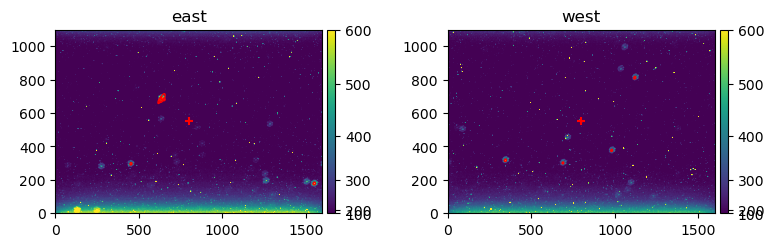

cam: east focus: 34.0 srcs: 5
cam: west focus: 34.0 srcs: 4


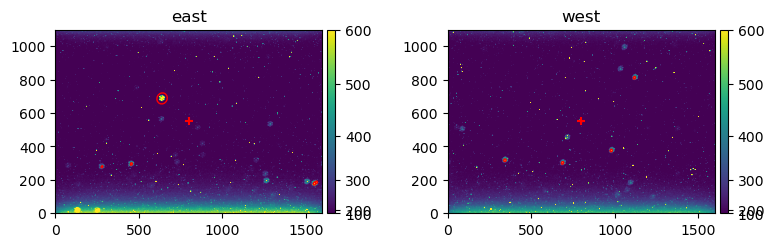

cam: east focus: 34.5 srcs: 7
cam: west focus: 34.5 srcs: 6


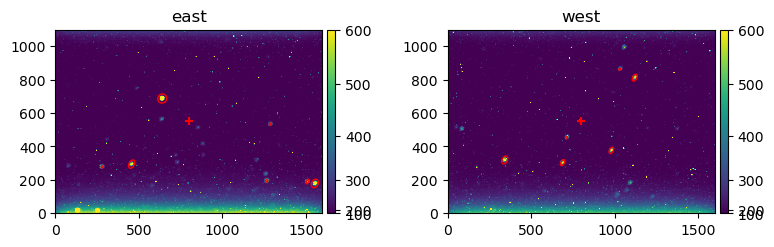

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 10.5+-3.2.
INFO:lvmagp.focus.focusseries.photometry:Found median radius of 11.3+-3.6.


cam: east focus: 35.0 srcs: 8
cam: west focus: 35.0 srcs: 8


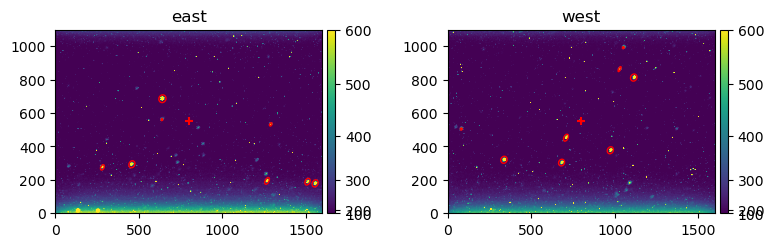

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 8.7+-0.7.
INFO:lvmagp.focus.focusseries.photometry:Found median radius of 9.1+-1.8.


cam: east focus: 35.5 srcs: 9
cam: west focus: 35.5 srcs: 10


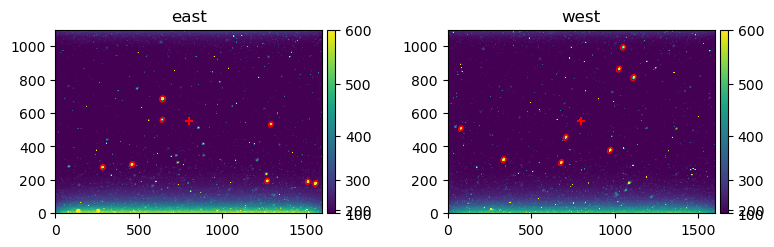

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 5.7+-0.9.
INFO:lvmagp.focus.focusseries.photometry:Found median radius of 6.7+-1.3.


cam: east focus: 36.0 srcs: 18
cam: west focus: 36.0 srcs: 13


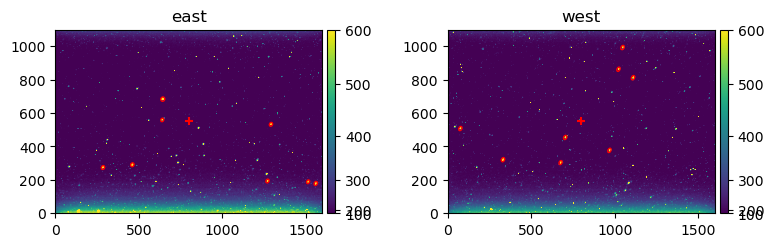

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 6.0+-0.8.
INFO:lvmagp.focus.focusseries.photometry:Found median radius of 3.9+-0.7.


cam: east focus: 36.5 srcs: 21
cam: west focus: 36.5 srcs: 19


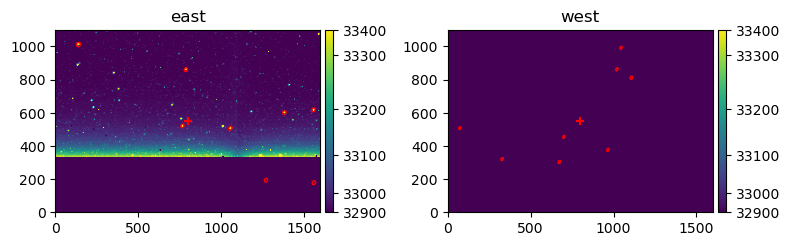

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 3.7+-0.4.
INFO:lvmagp.focus.focusseries.photometry:Found median radius of 3.7+-0.4.


cam: east focus: 37.0 srcs: 21
cam: west focus: 37.0 srcs: 19


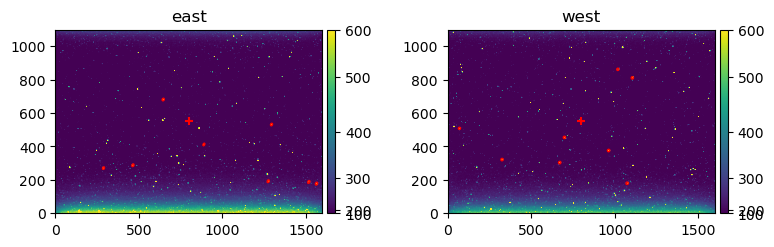

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 4.7+-0.6.
INFO:lvmagp.focus.focusseries.photometry:Found median radius of 4.9+-0.7.


cam: east focus: 37.5 srcs: 25
cam: west focus: 37.5 srcs: 21


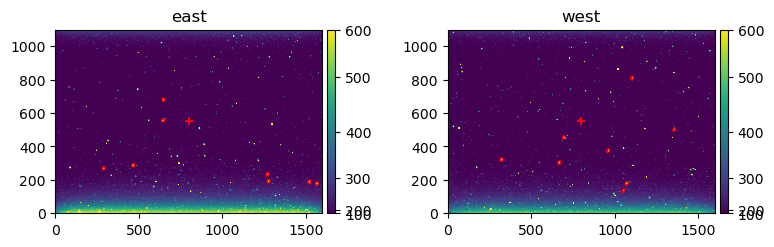

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 8.1+-0.5.
INFO:lvmagp.focus.focusseries.photometry:Found median radius of 7.9+-1.4.


cam: east focus: 38.0 srcs: 15
cam: west focus: 38.0 srcs: 12


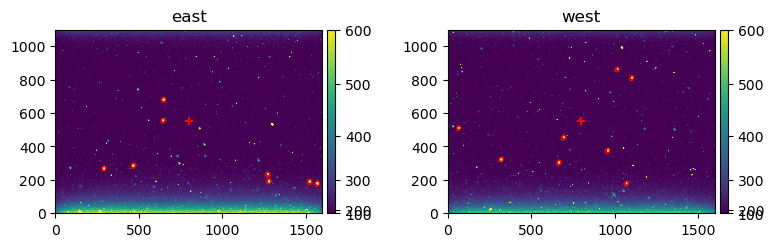

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 10.8+-0.3.
INFO:lvmagp.focus.focusseries.photometry:Found median radius of 10.9+-0.4.


cam: east focus: 38.5 srcs: 8
cam: west focus: 38.5 srcs: 9


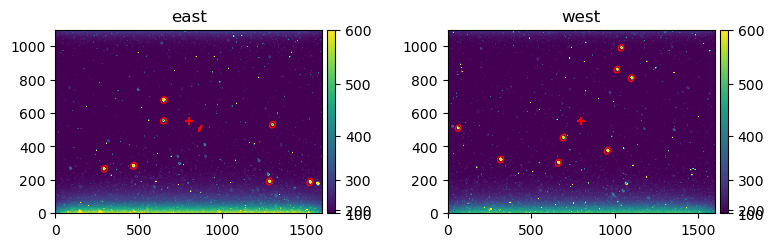

DEBUG:lvm_tel_focus:foc move to position 36.85254433649841 dt


[[3.68478231e+01 4.16663654e-03]
 [3.68572656e+01 1.11356409e-03]]
best focus [3.68525443e+01 2.64010031e-03]
best focus images: ['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000023.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000023.fits']


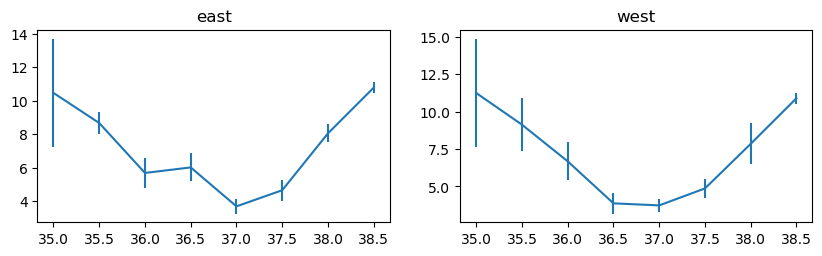

In [19]:
await find_foc(guess=36.) #maybe you have to adjust the guess, if best focus is around 36

In [20]:
await tel.km.moveToHome()

{'Reachable': True,
 'AtHome': False,
 'Moving': False,
 'PositionSwitchStatus': 0,
 'Position': -135.0,
 'DeviceEncoder': {'Position': 0.0, 'Unit': 'STEPS'},
 'Velocity': 0.0,
 'AtLimit': True,
 'CurrentTime': 982484262.0,
 'Simulate': False,
 'SkyPA': -270.0}

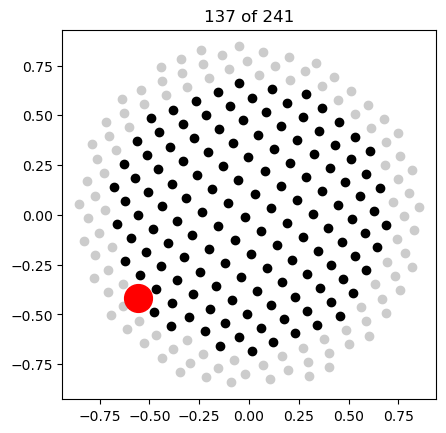

0.8020635064785394 -2.500025812715695
<SkyCoord (AltAz: obstime=2023-03-09 01:43:25.086812, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (216.75907226, 45.95485382)>
<SkyCoord (ICRS): (ra, dec) in deg
    (72.29866056, -56.71862836)>
ra_h:dec_d 4.8199334996853:-56.7184183456135
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000160.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000160.fits']
---------------------------------


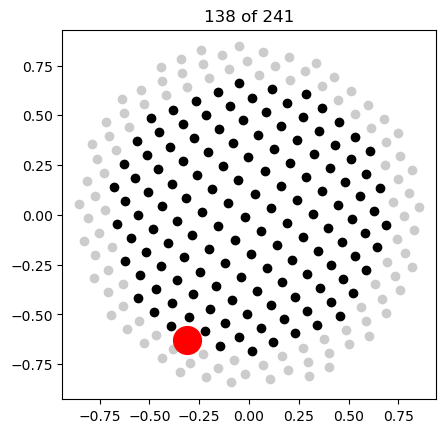

0.793404347802674 -2.0299343209523077
<SkyCoord (AltAz: obstime=2023-03-09 01:43:43.823159, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (243.69333072, 45.45872058)>
<SkyCoord (ICRS): (ra, dec) in deg
    (68.45974355, -38.17403952)>
ra_h:dec_d 4.56399261116515:-38.1740171789773
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000161.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000161.fits']
---------------------------------


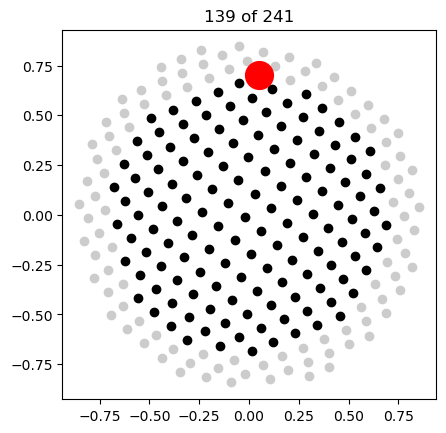

0.78765056253104 1.5023057784251033
<SkyCoord (AltAz: obstime=2023-03-09 01:44:00.301356, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (86.07578064, 45.12905296)>
<SkyCoord (ICRS): (ra, dec) in deg
    (169.08287118, -17.41381606)>
ra_h:dec_d 11.2721991831341:-17.4137618741612
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000162.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000162.fits']
---------------------------------


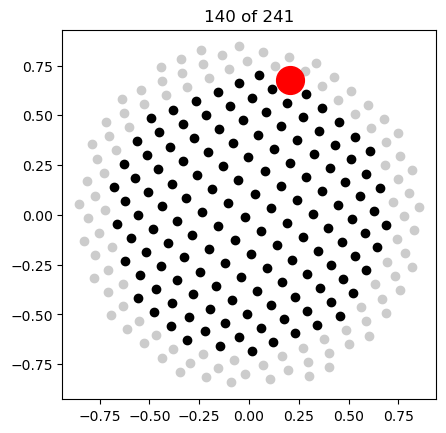

0.7847331511848127 1.2745135833162402
<SkyCoord (AltAz: obstime=2023-03-09 01:44:22.822734, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (73.02424926, 44.96189761)>
<SkyCoord (ICRS): (ra, dec) in deg
    (164.89622595, -9.19412988)>
ra_h:dec_d 10.9930898908819:-9.19422517889954
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000163.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000163.fits']
---------------------------------


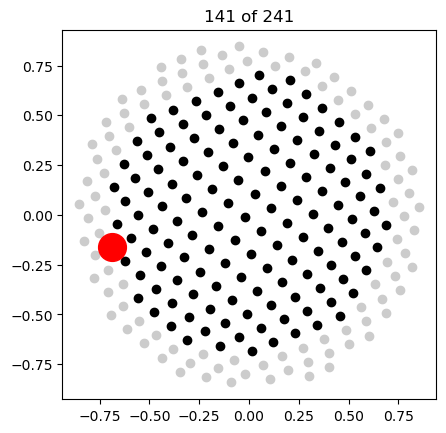

0.784290745497101 -2.9142638430773267
<SkyCoord (AltAz: obstime=2023-03-09 01:44:38.134609, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (193.0249814, 44.93654963)>
<SkyCoord (ICRS): (ra, dec) in deg
    (92.64663596, -71.01453317)>
ra_h:dec_d 6.17645804042566:-71.014566737567
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000164.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000164.fits']
---------------------------------


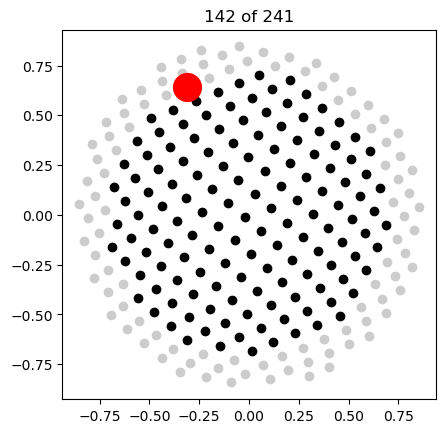

0.7758128563953303 2.0188842452356495
<SkyCoord (AltAz: obstime=2023-03-09 01:44:57.291696, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (115.67354658, 44.45080236)>
<SkyCoord (ICRS): (ra, dec) in deg
    (176.0309777, -37.46308544)>
ra_h:dec_d 6.17643914176263:-71.0146321747097
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000165.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000165.fits']
---------------------------------


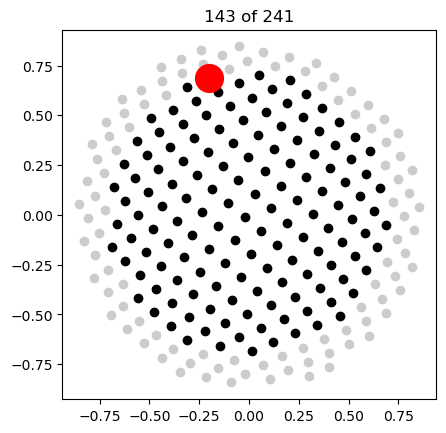

0.772281669113232 1.8570406089659288
<SkyCoord (AltAz: obstime=2023-03-09 01:45:07.309419, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (106.40058928, 44.24848024)>
<SkyCoord (ICRS): (ra, dec) in deg
    (175.08505577, -30.88275031)>
ra_h:dec_d 11.6723539584793:-30.8828349825866
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000166.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000166.fits']
---------------------------------


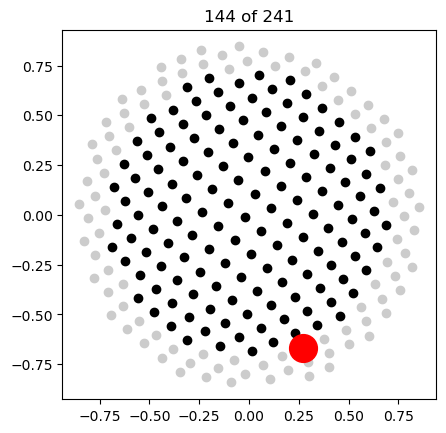

0.7680689046107447 -1.1847460968952894
<SkyCoord (AltAz: obstime=2023-03-09 01:45:24.636365, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (292.11904885, 44.00710661)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.8259348, -5.76063735)>
ra_h:dec_d 5.321739745556:-5.76056235589388
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000167.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000167.fits']
---------------------------------


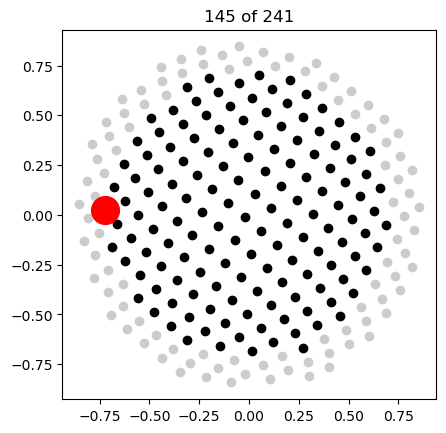

0.7654223498676096 3.105432797310311
<SkyCoord (AltAz: obstime=2023-03-09 01:45:49.449083, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (177.92819285, 43.85547019)>
<SkyCoord (ICRS): (ra, dec) in deg
    (128.12630751, -74.97497444)>
ra_h:dec_d 8.54177098705489:-74.9749645275367
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000168.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000168.fits']
---------------------------------


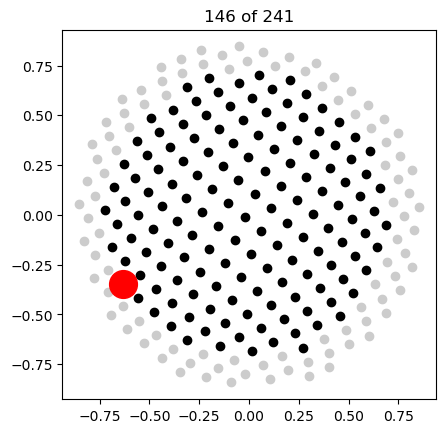

0.7640938593877662 -2.643168056638046
<SkyCoord (AltAz: obstime=2023-03-09 01:46:11.653148, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (208.55762581, 43.77935329)>
<SkyCoord (ICRS): (ra, dec) in deg
    (73.06283734, -62.91986174)>
ra_h:dec_d 4.87087547895444:-62.9197471163917
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000169.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000169.fits']
---------------------------------


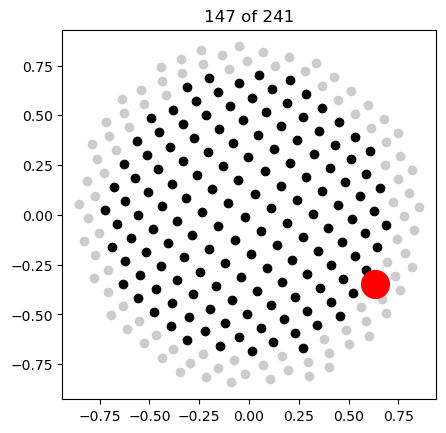

0.7629941848882963 -0.504432076728682
<SkyCoord (AltAz: obstime=2023-03-09 01:46:30.838217, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (331.09817095, 43.71634659)>
<SkyCoord (ICRS): (ra, dec) in deg
    (101.12698105, 12.63416635)>
ra_h:dec_d 6.74180744296543:12.6341862524348
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000170.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000170.fits']
---------------------------------


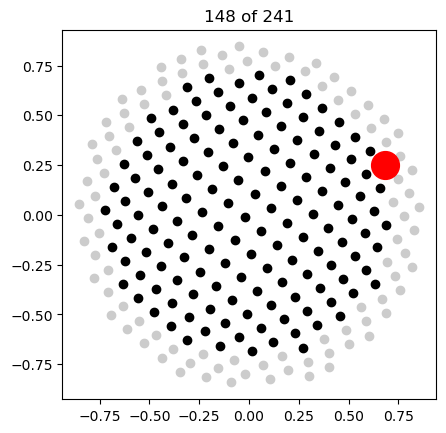

0.7585059714348648 0.3535310359632155
<SkyCoord (AltAz: obstime=2023-03-09 01:46:51.662162, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (20.25583629, 43.4591909)>
<SkyCoord (ICRS): (ra, dec) in deg
    (137.28451754, 15.28720792)>
ra_h:dec_d 9.15230818516671:15.2872000061896
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000171.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000171.fits']
---------------------------------


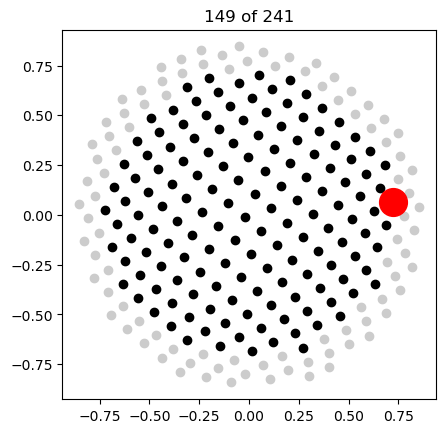

0.7567930269354234 0.09048058492882798
<SkyCoord (AltAz: obstime=2023-03-09 01:47:10.846534, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (5.18415564, 43.36104641)>
<SkyCoord (ICRS): (ra, dec) in deg
    (126.21150834, 17.55463221)>
ra_h:dec_d 8.41410505894835:17.5545728170585
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000172.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000172.fits']
---------------------------------


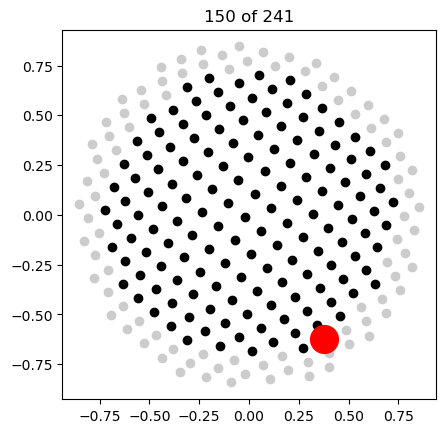

0.7542550328796063 -1.0240049814416579
<SkyCoord (AltAz: obstime=2023-03-09 01:47:27.219400, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (301.32883636, 43.21563006)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.86654147, -0.04748492)>
ra_h:dec_d 5.59110738615202:-0.0475968305455709
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000173.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000173.fits']
---------------------------------


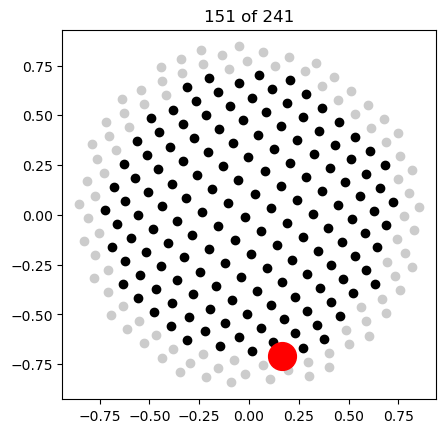

0.7535710224141974 -1.34120825822408
<SkyCoord (AltAz: obstime=2023-03-09 01:47:46.058081, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (283.15442736, 43.17643915)>
<SkyCoord (ICRS): (ra, dec) in deg
    (76.18291104, -10.78459219)>
ra_h:dec_d 5.07885986654786:-10.7845888821032
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000174.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000174.fits']
---------------------------------


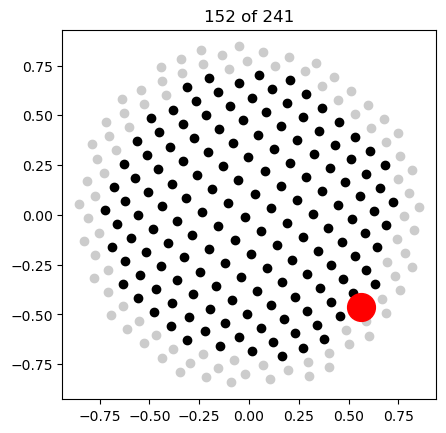

0.7519081782740121 -0.6884151166505362
<SkyCoord (AltAz: obstime=2023-03-09 01:48:01.721743, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (320.55671926, 43.0811652)>
<SkyCoord (ICRS): (ra, dec) in deg
    (94.43895272, 9.3401917)>
ra_h:dec_d 6.29594575386297:9.34020647606288
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000175.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000175.fits']
---------------------------------


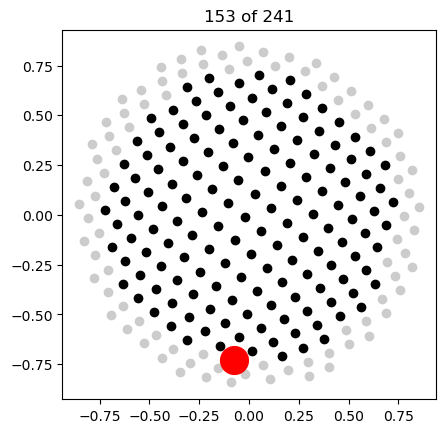

0.7512209714927389 -1.6762154676763292
<SkyCoord (AltAz: obstime=2023-03-09 01:48:18.126515, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (263.95992815, 43.04179115)>
<SkyCoord (ICRS): (ra, dec) in deg
    (70.23014339, -23.50607817)>
ra_h:dec_d 4.68200969566604:-23.5060494479544
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000176.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000176.fits']
---------------------------------


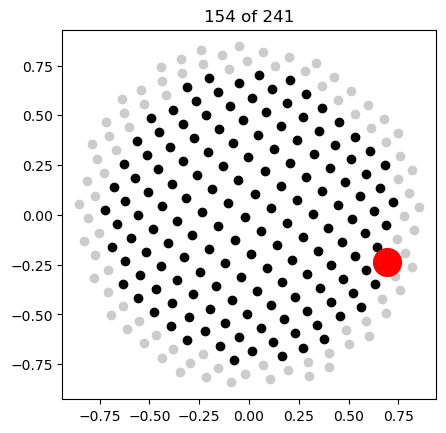

0.7511908212702341 -0.3267967247703787
<SkyCoord (AltAz: obstime=2023-03-09 01:48:35.740345, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (341.27592691, 43.04006367)>
<SkyCoord (ICRS): (ra, dec) in deg
    (108.49416621, 15.9700642)>
ra_h:dec_d 7.23295845198096:15.9699960540837
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000177.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000177.fits']
---------------------------------


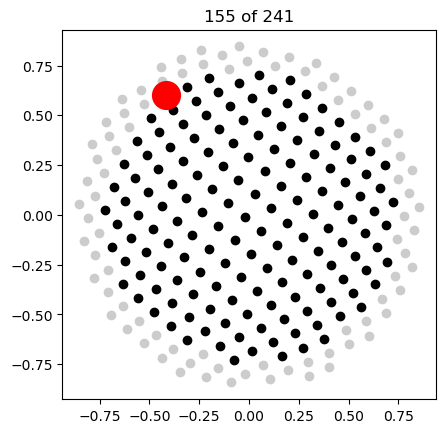

0.7511046407218754 2.1796655630430712
<SkyCoord (AltAz: obstime=2023-03-09 01:48:53.504338, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (124.88563751, 43.03512589)>
<SkyCoord (ICRS): (ra, dec) in deg
    (179.40331758, -44.01942119)>
ra_h:dec_d 11.9602474716042:-44.0195675694036
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000178.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000178.fits']
---------------------------------


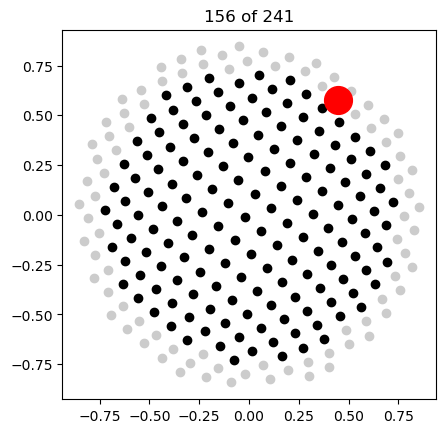

0.7485642938432887 0.9106333974552873
<SkyCoord (AltAz: obstime=2023-03-09 01:49:17.840185, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (52.17545036, 42.88957473)>
<SkyCoord (ICRS): (ra, dec) in deg
    (158.26361895, 3.73062462)>
ra_h:dec_d 10.5509111092521:3.73051105050004
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000179.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000179.fits']
---------------------------------


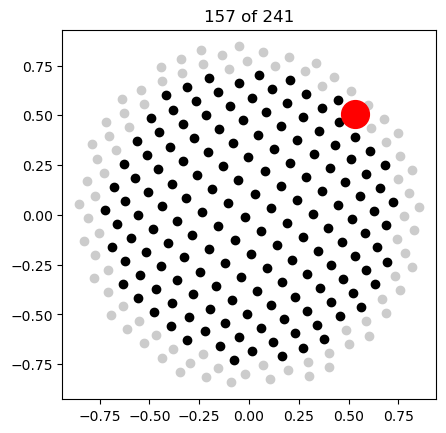

0.7440686061908892 0.761816804854569
<SkyCoord (AltAz: obstime=2023-03-09 01:49:45.024556, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (43.64888768, 42.6319908)>
<SkyCoord (ICRS): (ra, dec) in deg
    (153.77202309, 8.00211363)>
ra_h:dec_d 10.2514698139413:8.00204410740427
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000180.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000180.fits']
---------------------------------


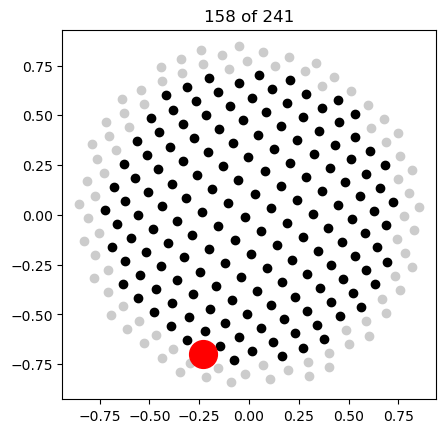

0.7426215763385791 -1.889121993320371
<SkyCoord (AltAz: obstime=2023-03-09 01:49:59.934013, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (251.7612828, 42.5490821)>
<SkyCoord (ICRS): (ra, dec) in deg
    (67.51023867, -32.01953255)>
ra_h:dec_d 4.5006917983656:-32.0196911877921
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000181.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000181.fits']
---------------------------------


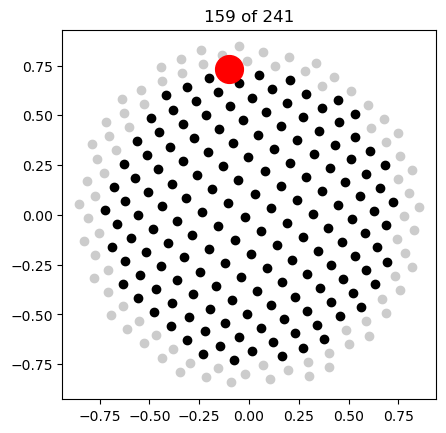

0.7408446529658023 1.7079451829076413
<SkyCoord (AltAz: obstime=2023-03-09 01:50:21.426394, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (97.85805062, 42.44727189)>
<SkyCoord (ICRS): (ra, dec) in deg
    (176.57061735, -24.41970269)>
ra_h:dec_d 11.7713889998722:-24.4196944461546
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000182.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000182.fits']
---------------------------------


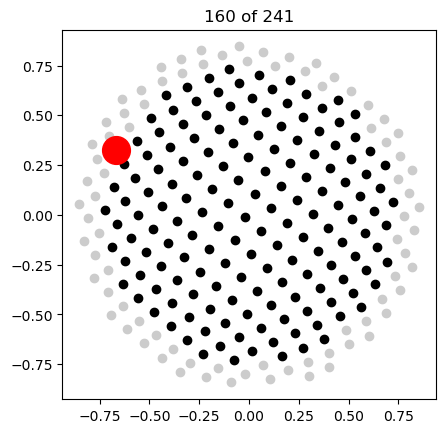

0.731912276437534 2.687390746979612
<SkyCoord (AltAz: obstime=2023-03-09 01:50:45.113356, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (153.9761477, 41.93548441)>
<SkyCoord (ICRS): (ra, dec) in deg
    (174.6313808, -65.19498837)>
ra_h:dec_d 11.6421126018015:-65.1951606739236
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000183.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000183.fits']
---------------------------------


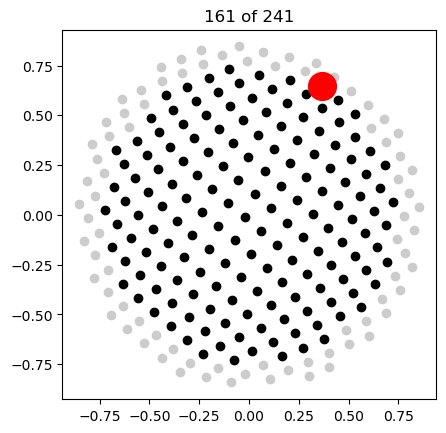

0.7300069854631611 1.058854085704558
<SkyCoord (AltAz: obstime=2023-03-09 01:51:11.944634, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (60.66787023, 41.82631928)>
<SkyCoord (ICRS): (ra, dec) in deg
    (163.8160826, -0.10924559)>
ra_h:dec_d 10.9210859053629:-0.109294925673268
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000184.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000184.fits']
---------------------------------


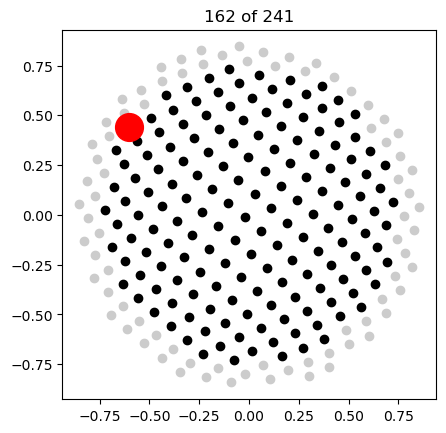

0.7289673064996842 2.508829889482794
<SkyCoord (AltAz: obstime=2023-03-09 01:51:39.154079, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (143.74536418, 41.76675007)>
<SkyCoord (ICRS): (ra, dec) in deg
    (180.00463719, -57.9748331)>
ra_h:dec_d 12.0003318080955:-57.9749836616227
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000185.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000185.fits']
---------------------------------


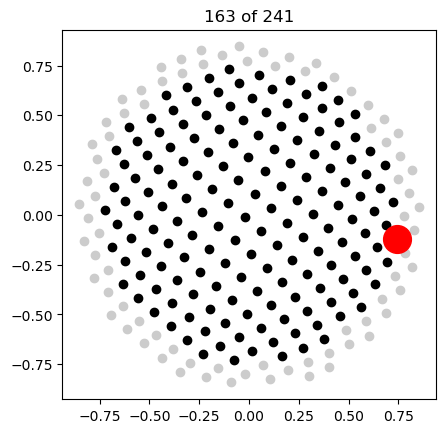

0.7208622860208128 -0.16031130195388135
<SkyCoord (AltAz: obstime=2023-03-09 01:52:06.055236, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (350.81483899, 41.3023666)>
<SkyCoord (ICRS): (ra, dec) in deg
    (116.19458601, 19.23814276)>
ra_h:dec_d 7.74631304576423:19.2381083142421
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000186.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000186.fits']
---------------------------------


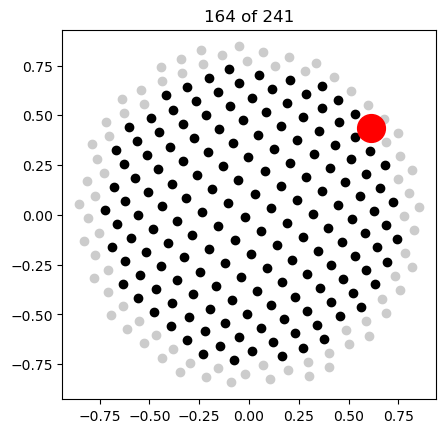

0.7193359974289302 0.6197282169859514
<SkyCoord (AltAz: obstime=2023-03-09 01:52:31.138925, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (35.50781128, 41.2149167)>
<SkyCoord (ICRS): (ra, dec) in deg
    (150.20043404, 12.59166318)>
ra_h:dec_d 10.0133760718425:12.5913999982988
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000187.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000187.fits']
---------------------------------


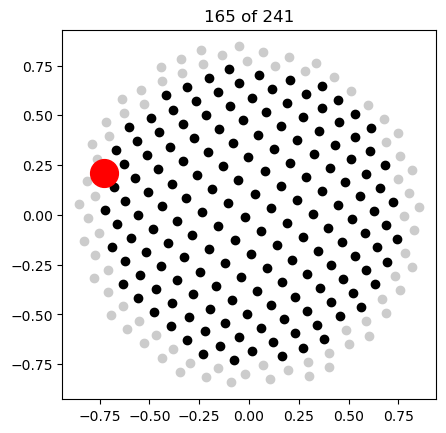

0.7139094582229182 2.857725971632081
<SkyCoord (AltAz: obstime=2023-03-09 01:52:50.568400, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (163.73563718, 40.90399891)>
<SkyCoord (ICRS): (ra, dec) in deg
    (167.57379819, -72.06043102)>
ra_h:dec_d 11.1715955462779:-72.0604908686801
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000188.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000188.fits']
---------------------------------


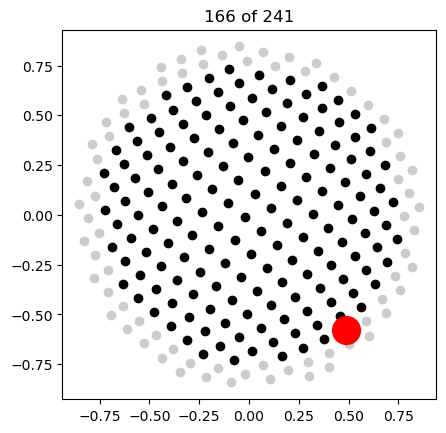

0.7135506610204787 -0.8717711526069408
<SkyCoord (AltAz: obstime=2023-03-09 01:53:18.139387, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (310.05119225, 40.88344135)>
<SkyCoord (ICRS): (ra, dec) in deg
    (88.21768758, 6.20340879)>
ra_h:dec_d 5.88117836558143:6.20351216917838
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000189.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000189.fits']
---------------------------------


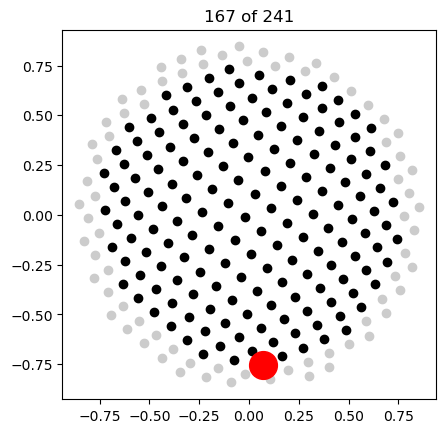

0.712085212922978 -1.4804017118087418
<SkyCoord (AltAz: obstime=2023-03-09 01:53:42.682327, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (275.17922993, 40.79947735)>
<SkyCoord (ICRS): (ra, dec) in deg
    (72.69737435, -14.93131769)>
ra_h:dec_d 4.84649560179708:-14.9313092336157
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000190.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000190.fits']
---------------------------------


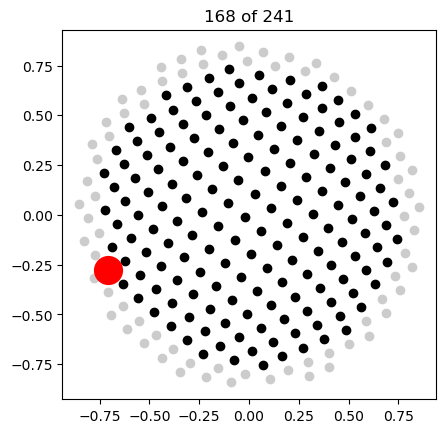

0.711342924068017 -2.7711317975378056
<SkyCoord (AltAz: obstime=2023-03-09 01:53:59.829701, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (201.22584353, 40.75694734)>
<SkyCoord (ICRS): (ra, dec) in deg
    (74.14527419, -69.11282929)>
ra_h:dec_d 4.94302753784757:-69.1128690543865
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000191.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000191.fits']
---------------------------------


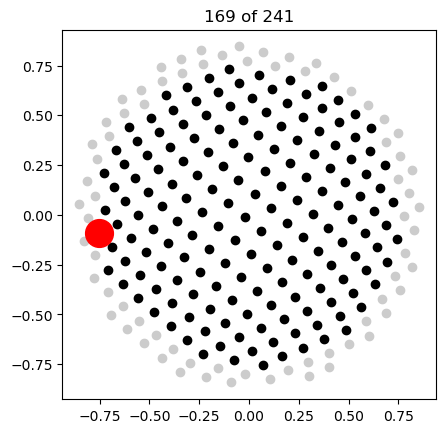

0.7112529839569238 -3.0243223560338484
<SkyCoord (AltAz: obstime=2023-03-09 01:54:19.349104, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (186.71909311, 40.75179415)>
<SkyCoord (ICRS): (ra, dec) in deg
    (101.35957115, -77.00518308)>
ra_h:dec_d 6.75729612360306:-77.0052392410293
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000192.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000192.fits']
---------------------------------


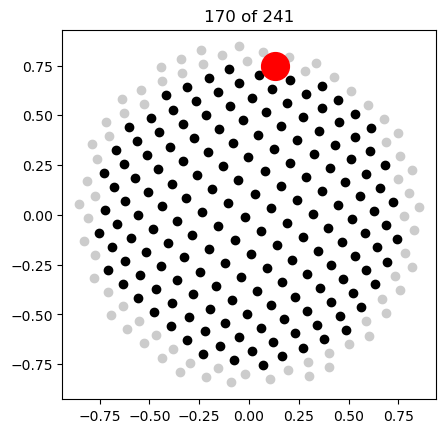

0.7083961453946037 1.3946370745479937
<SkyCoord (AltAz: obstime=2023-03-09 01:54:35.834629, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (79.90681832, 40.58810935)>
<SkyCoord (ICRS): (ra, dec) in deg
    (173.87891408, -11.35302726)>
ra_h:dec_d 11.5919460446954:-11.353047358251
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000193.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000193.fits']
---------------------------------


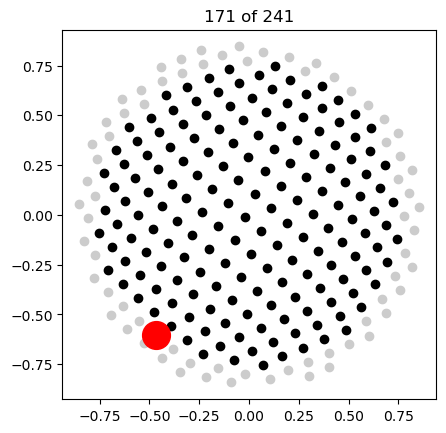

0.702992818059447 -2.2329848934864422
<SkyCoord (AltAz: obstime=2023-03-09 01:54:54.856416, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (232.05938989, 40.2785215)>
<SkyCoord (ICRS): (ra, dec) in deg
    (63.68478149, -46.41480202)>
ra_h:dec_d 4.24565647176808:-46.4149130311397
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000194.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000194.fits']
---------------------------------


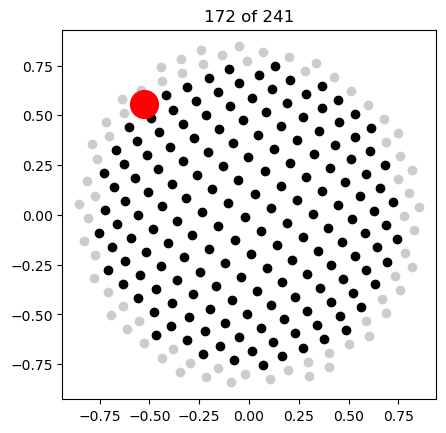

0.7005710701688704 2.327622254196468
<SkyCoord (AltAz: obstime=2023-03-09 01:55:17.651884, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (133.36293147, 40.13976557)>
<SkyCoord (ICRS): (ra, dec) in deg
    (185.21684492, -50.37385227)>
ra_h:dec_d 12.3478153540014:-50.3740042856349
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000195.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000195.fits']
---------------------------------


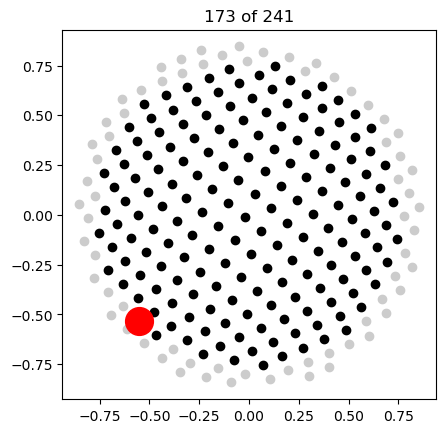

0.6978170388225379 -2.3763989819737663
<SkyCoord (AltAz: obstime=2023-03-09 01:55:43.249762, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (223.84236789, 39.9819712)>
<SkyCoord (ICRS): (ra, dec) in deg
    (63.57483007, -52.69827872)>
ra_h:dec_d 4.23832871594409:-52.6983285490754
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000196.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000196.fits']
---------------------------------


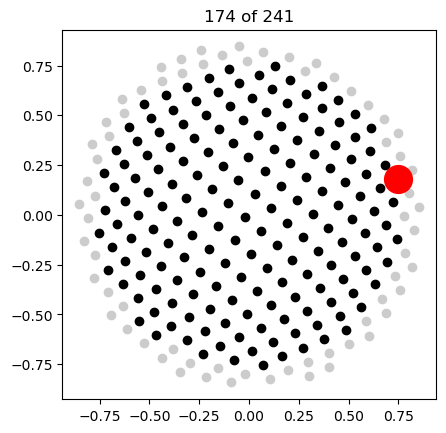

0.6937986197170892 0.2368478594893555
<SkyCoord (AltAz: obstime=2023-03-09 01:56:08.846111, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (13.57038274, 39.75173274)>
<SkyCoord (ICRS): (ra, dec) in deg
    (135.58382547, 20.18675628)>
ra_h:dec_d 9.0389386604024:20.186708253673
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000197.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000197.fits']
---------------------------------


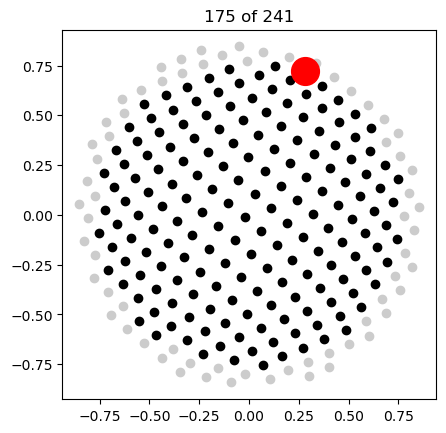

0.6862766336096165 1.1982445643664443
<SkyCoord (AltAz: obstime=2023-03-09 01:56:28.355096, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (68.65435636, 39.32075468)>
<SkyCoord (ICRS): (ra, dec) in deg
    (170.83511634, -3.36672341)>
ra_h:dec_d 11.3890275721247:-3.36689727647189
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000198.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000198.fits']
---------------------------------


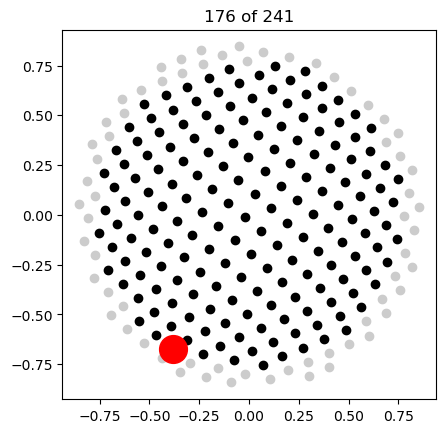

0.6851829654981583 -2.0891816052857988
<SkyCoord (AltAz: obstime=2023-03-09 01:56:47.250303, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (240.29871138, 39.25809212)>
<SkyCoord (ICRS): (ra, dec) in deg
    (63.45295966, -40.02219832)>
ra_h:dec_d 4.2302023048681:-40.0223435082054
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000199.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000199.fits']
---------------------------------


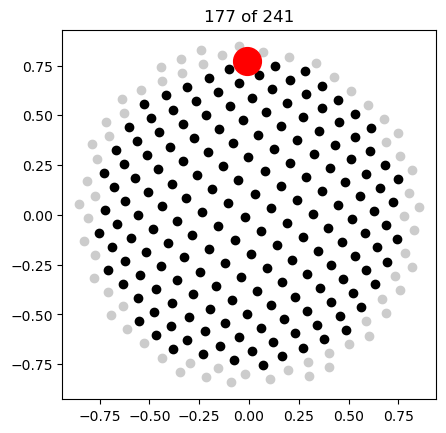

0.6843650169905103 1.5827381638290716
<SkyCoord (AltAz: obstime=2023-03-09 01:57:10.232333, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (90.68421686, 39.21122712)>
<SkyCoord (ICRS): (ra, dec) in deg
    (179.50667193, -18.20767426)>
ra_h:dec_d 11.9671253362856:-18.2076118926417
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000200.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000200.fits']
---------------------------------


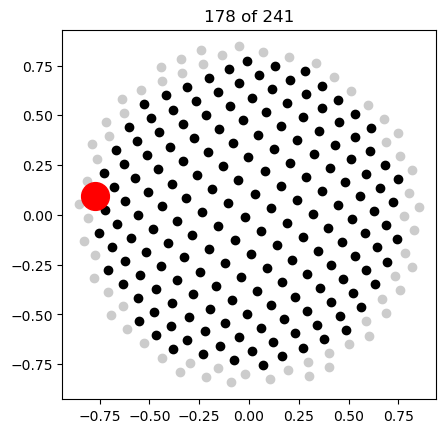

0.679260227933523 3.016625844464743
<SkyCoord (AltAz: obstime=2023-03-09 01:57:33.735247, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (172.83992926, 38.91874425)>
<SkyCoord (ICRS): (ra, dec) in deg
    (154.13113208, -78.33603285)>
ra_h:dec_d 10.2754193419576:-78.336067185459
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000201.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000201.fits']
---------------------------------


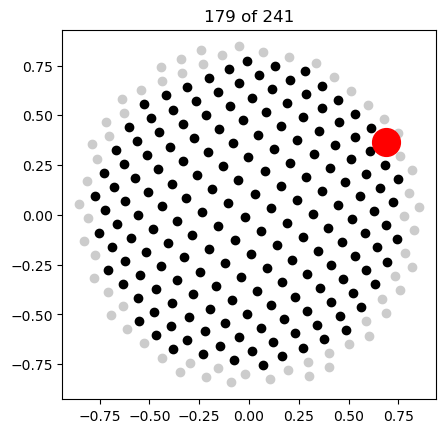

0.677744346822511 0.4891182837730629
<SkyCoord (AltAz: obstime=2023-03-09 01:57:51.349385, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (28.02441334, 38.83189066)>
<SkyCoord (ICRS): (ra, dec) in deg
    (147.48961749, 17.40941815)>
ra_h:dec_d 9.83265383574837:17.4093322667392
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000202.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000202.fits']
---------------------------------


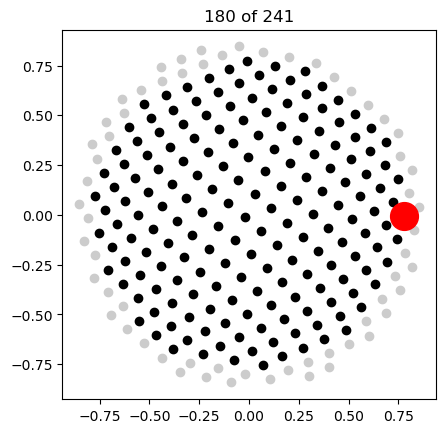

0.6761693026862389 -0.0066845710826208896
<SkyCoord (AltAz: obstime=2023-03-09 01:58:13.427954, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (359.61700229, 38.74164728)>
<SkyCoord (ICRS): (ra, dec) in deg
    (124.69709506, 22.32625811)>
ra_h:dec_d 8.31314492444204:22.3262683058361
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000203.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000203.fits']
---------------------------------


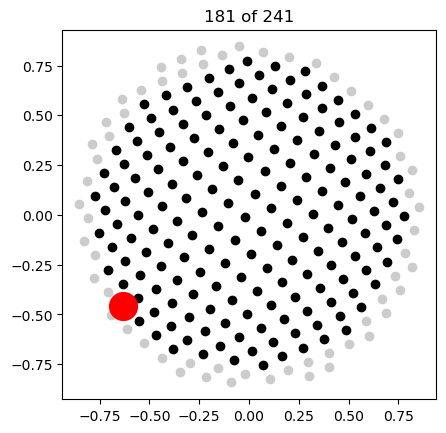

0.6727300475119607 -2.513063282193731
<SkyCoord (AltAz: obstime=2023-03-09 01:58:31.643560, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (216.01208028, 38.54459247)>
<SkyCoord (ICRS): (ra, dec) in deg
    (62.71944529, -58.86344914)>
ra_h:dec_d 4.18129818212055:-58.8634321282996
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000204.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000204.fits']
---------------------------------


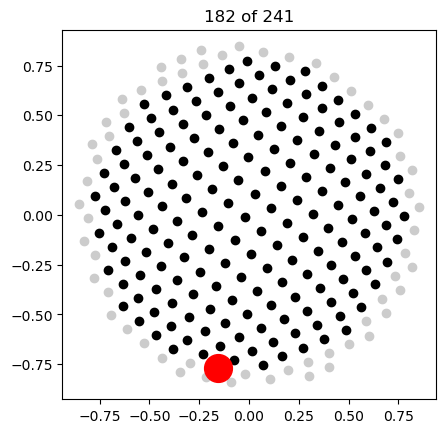

0.666383333350433 -1.7695060963594673
<SkyCoord (AltAz: obstime=2023-03-09 01:58:51.734295, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (258.61476886, 38.18095254)>
<SkyCoord (ICRS): (ra, dec) in deg
    (66.41449848, -25.86113142)>
ra_h:dec_d 4.42763607914261:-25.8610163734985
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000205.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000205.fits']
---------------------------------


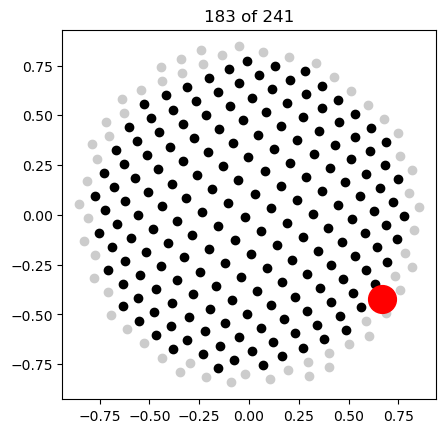

0.664149729893484 -0.562927799751065
<SkyCoord (AltAz: obstime=2023-03-09 01:59:09.308348, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (327.7466129, 38.05297649)>
<SkyCoord (ICRS): (ra, dec) in deg
    (99.27143322, 16.4923732)>
ra_h:dec_d 6.61810743973081:16.4923466974572
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000206.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000206.fits']
---------------------------------


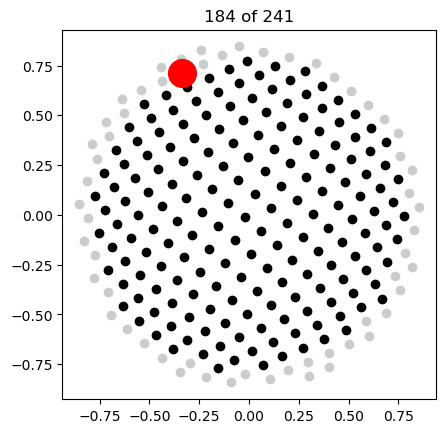

0.6619705212484234 2.0089072672300836
<SkyCoord (AltAz: obstime=2023-03-09 01:59:27.632891, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (115.10190785, 37.92811703)>
<SkyCoord (ICRS): (ra, dec) in deg
    (187.63966309, -36.0782871)>
ra_h:dec_d 12.5093386068664:-36.0786613644432
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000207.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000207.fits']
---------------------------------


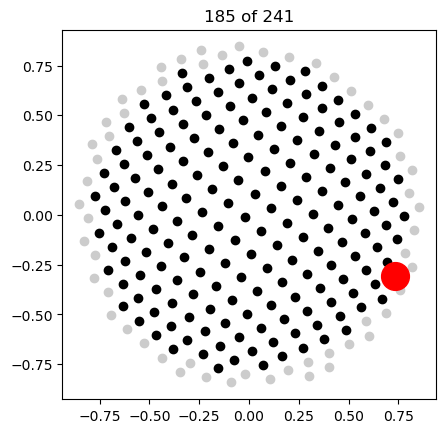

0.6564031768798462 -0.39593628814142023
<SkyCoord (AltAz: obstime=2023-03-09 01:59:52.000411, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (337.31452173, 37.60913169)>
<SkyCoord (ICRS): (ra, dec) in deg
    (106.44771584, 20.1160106)>
ra_h:dec_d 7.09652489280478:20.1161349352517
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000208.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000208.fits']
---------------------------------


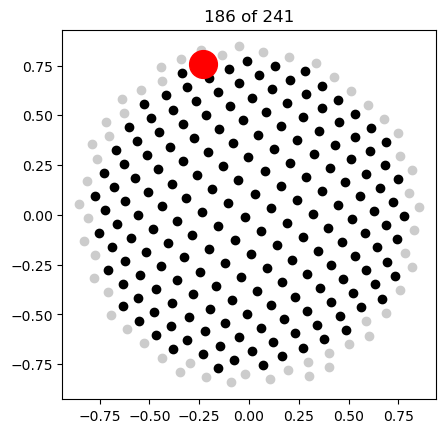

0.6551122385518346 1.868573478262699
<SkyCoord (AltAz: obstime=2023-03-09 02:00:16.149892, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (107.06137401, 37.53516638)>
<SkyCoord (ICRS): (ra, dec) in deg
    (186.57746216, -29.79758533)>
ra_h:dec_d 7.09652211512476:20.1160322601097
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000209.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000209.fits']
---------------------------------


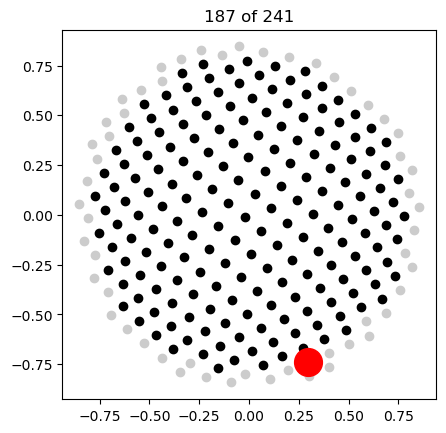

0.6524036878110622 -1.1883759534625344
<SkyCoord (AltAz: obstime=2023-03-09 02:00:26.252585, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (291.91107339, 37.37997785)>
<SkyCoord (ICRS): (ra, dec) in deg
    (78.0928599, -2.03247758)>
ra_h:dec_d 5.20620335656887:-2.03233833143356
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000210.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000210.fits']
---------------------------------


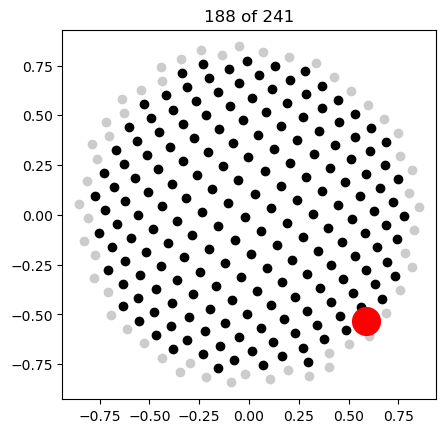

0.6495559828271819 -0.7365389374286484
<SkyCoord (AltAz: obstime=2023-03-09 02:00:46.452115, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (317.79942744, 37.21681637)>
<SkyCoord (ICRS): (ra, dec) in deg
    (92.39766283, 12.8719171)>
ra_h:dec_d 6.15985962259065:12.871947546899
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000211.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000211.fits']
---------------------------------


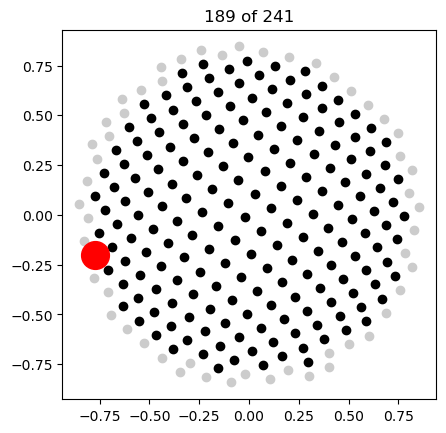

0.6473451732749128 -2.883840296722285
<SkyCoord (AltAz: obstime=2023-03-09 02:01:02.506216, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (194.76812221, 37.09014632)>
<SkyCoord (ICRS): (ra, dec) in deg
    (73.27891603, -75.27510236)>
ra_h:dec_d 4.88527243629872:-75.2751338742236
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000212.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000212.fits']
---------------------------------


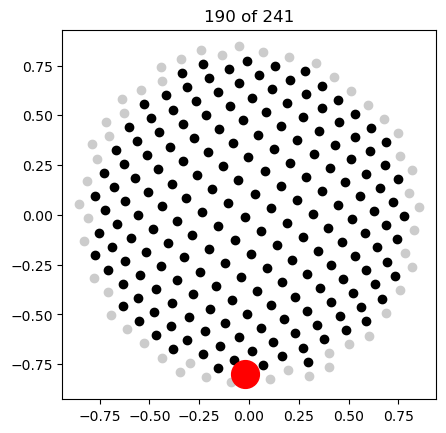

0.6469850406050922 -1.5931221399242363
<SkyCoord (AltAz: obstime=2023-03-09 02:01:24.495079, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (268.72082513, 37.06951223)>
<SkyCoord (ICRS): (ra, dec) in deg
    (68.93130832, -17.97336488)>
ra_h:dec_d 4.59542353735578:-17.9733263698699
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000213.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000213.fits']
---------------------------------


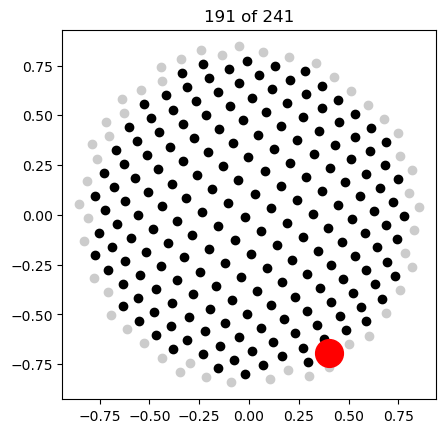

0.6428427030944813 -1.0478685263029608
<SkyCoord (AltAz: obstime=2023-03-09 02:01:44.118372, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (299.96155596, 36.83217378)>
<SkyCoord (ICRS): (ra, dec) in deg
    (81.94161918, 3.36125349)>
ra_h:dec_d 5.4627939462903:3.36130217555319
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000214.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000214.fits']
---------------------------------


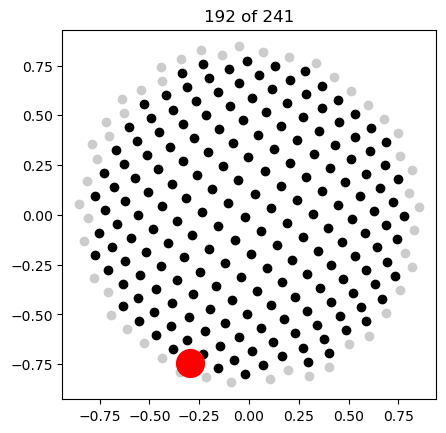

0.641677446556458 -1.9523542286890256
<SkyCoord (AltAz: obstime=2023-03-09 02:02:00.728898, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (248.13834258, 36.7654095)>
<SkyCoord (ICRS): (ra, dec) in deg
    (63.09503127, -33.49734659)>
ra_h:dec_d 4.20633490796012:-33.4973692984917
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000215.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000215.fits']
---------------------------------


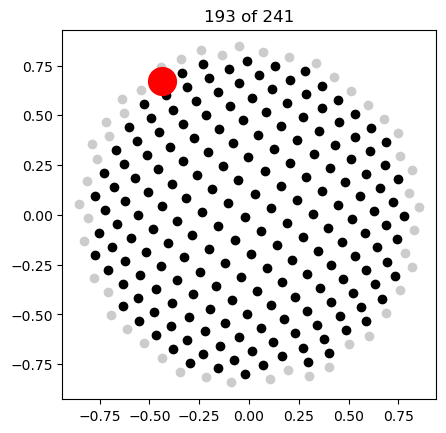

0.6416203826220864 2.1499364639904646
<SkyCoord (AltAz: obstime=2023-03-09 02:02:18.753902, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (123.18228561, 36.76213997)>
<SkyCoord (ICRS): (ra, dec) in deg
    (191.19234468, -42.22416197)>
ra_h:dec_d 12.7461760216735:-42.2243719719184
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000216.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000216.fits']
---------------------------------


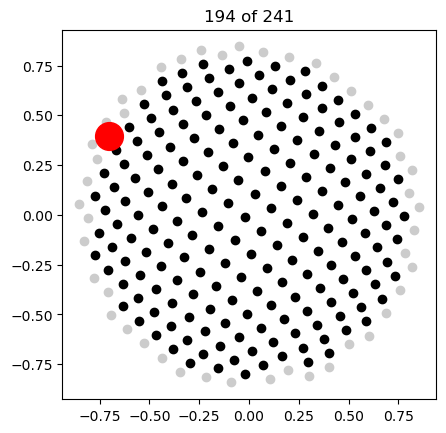

0.6348037566029593 2.625585374123257
<SkyCoord (AltAz: obstime=2023-03-09 02:02:44.634003, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (150.43496069, 36.37157607)>
<SkyCoord (ICRS): (ra, dec) in deg
    (191.87570123, -64.04036086)>
ra_h:dec_d 12.7917326119572:-64.0404343171784
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000217.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000217.fits']
---------------------------------


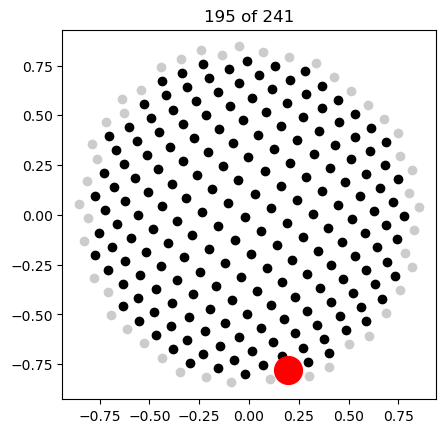

0.6343838638598395 -1.3239470389177366
<SkyCoord (AltAz: obstime=2023-03-09 02:03:00.713674, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (284.14342237, 36.34751799)>
<SkyCoord (ICRS): (ra, dec) in deg
    (74.44509432, -6.65076181)>
ra_h:dec_d 4.96301942962576:-6.65053005470309
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000218.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000218.fits']
---------------------------------


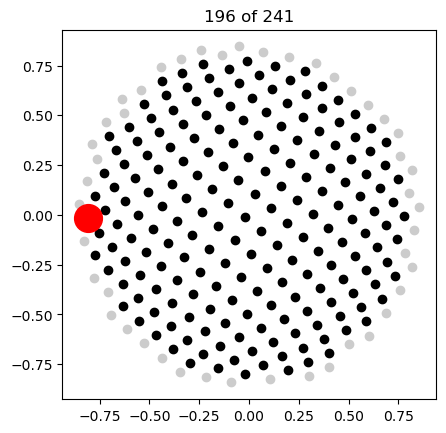

0.6318886360473968 -3.1196222349366978
<SkyCoord (AltAz: obstime=2023-03-09 02:03:24.645497, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (181.25881226, 36.20455197)>
<SkyCoord (ICRS): (ra, dec) in deg
    (119.17786944, -82.65719681)>
ra_h:dec_d 7.94521427684:-82.6571817287195
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000219.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000219.fits']
---------------------------------


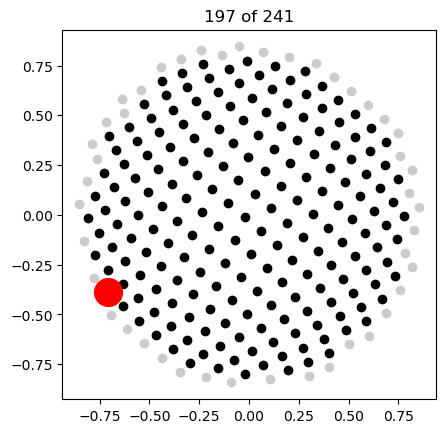

0.6311424763274605 -2.638936255370111
<SkyCoord (AltAz: obstime=2023-03-09 02:03:46.848058, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (208.80009016, 36.16180016)>
<SkyCoord (ICRS): (ra, dec) in deg
    (60.68283684, -64.86387614)>
ra_h:dec_d 4.04555349058864:-64.863768812069
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000220.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000220.fits']
---------------------------------


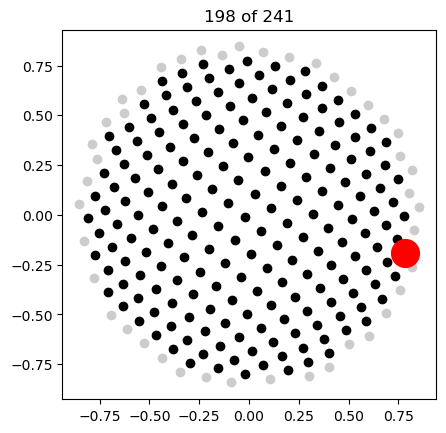

0.6308642138746868 -0.2385654888320747
<SkyCoord (AltAz: obstime=2023-03-09 02:04:05.541800, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (346.33120435, 36.1458569)>
<SkyCoord (ICRS): (ra, dec) in deg
    (114.46529917, 23.64591027)>
ra_h:dec_d 7.63103014169168:23.6458835996701
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000221.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000221.fits']
---------------------------------


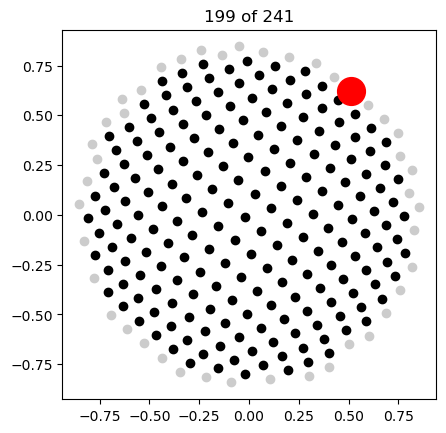

0.6307951710082556 0.8802070306669733
<SkyCoord (AltAz: obstime=2023-03-09 02:04:27.370032, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (50.43214795, 36.14190104)>
<SkyCoord (ICRS): (ra, dec) in deg
    (165.74760085, 9.56107649)>
ra_h:dec_d 11.0498601920536:9.56076386445595
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000222.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000222.fits']
---------------------------------


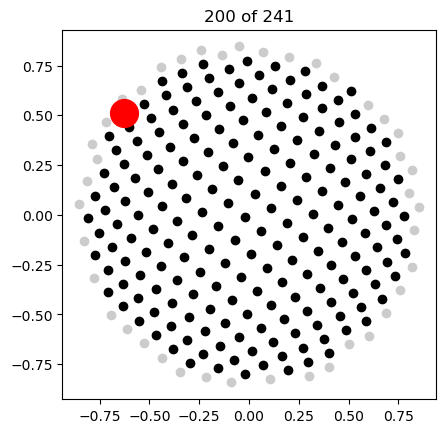

0.6283811492778746 2.456318512839004
<SkyCoord (AltAz: obstime=2023-03-09 02:04:49.003297, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (140.73668393, 36.00358778)>
<SkyCoord (ICRS): (ra, dec) in deg
    (194.32483464, -56.26577339)>
ra_h:dec_d 12.9550169849415:-56.2660798842165
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000223.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000223.fits']
---------------------------------


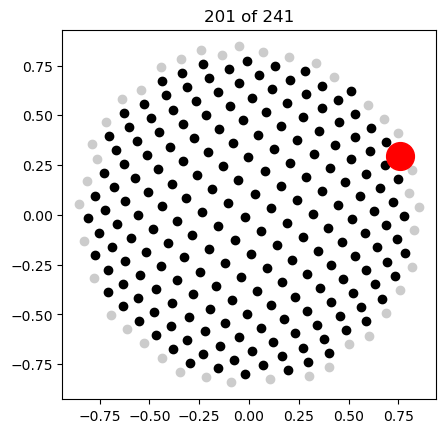

0.6227777835749947 0.3718134501960532
<SkyCoord (AltAz: obstime=2023-03-09 02:05:15.821253, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (21.30334146, 35.68253857)>
<SkyCoord (ICRS): (ra, dec) in deg
    (145.39280724, 22.37993535)>
ra_h:dec_d 9.69286056221583:22.379854784607
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000224.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000224.fits']
---------------------------------


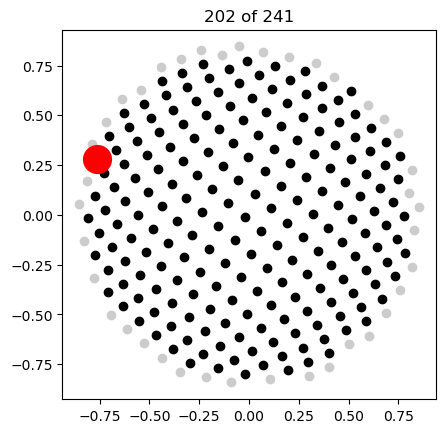

0.6207898997851641 2.786790187726421
<SkyCoord (AltAz: obstime=2023-03-09 02:05:42.280750, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (159.67131615, 35.56864122)>
<SkyCoord (ICRS): (ra, dec) in deg
    (190.68591184, -71.52188321)>
ra_h:dec_d 12.7124169126176:-71.5219809223312
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000225.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000225.fits']
---------------------------------


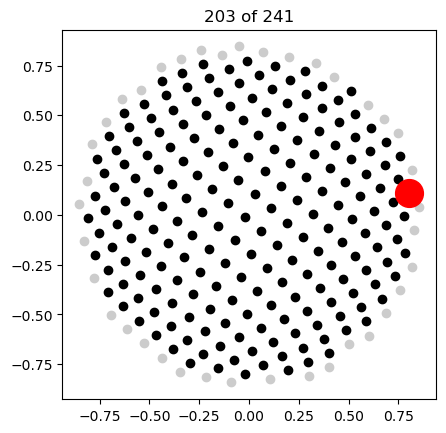

0.6207623576251982 0.13501060251341926
<SkyCoord (AltAz: obstime=2023-03-09 02:06:09.147450, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (7.73553771, 35.56706317)>
<SkyCoord (ICRS): (ra, dec) in deg
    (133.94652012, 25.10799973)>
ra_h:dec_d 8.92977245343743:25.1078763899573
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000226.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000226.fits']
---------------------------------


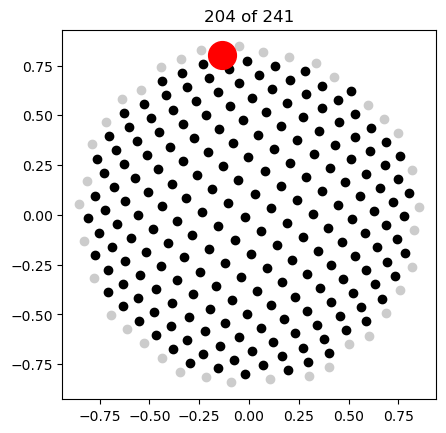

0.6207104806293262 1.7397920226734434
<SkyCoord (AltAz: obstime=2023-03-09 02:06:35.464000, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (99.68274013, 35.56409084)>
<SkyCoord (ICRS): (ra, dec) in deg
    (188.27042382, -23.55394436)>
ra_h:dec_d 12.5513901213568:-23.554197757577
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000227.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000227.fits']
---------------------------------


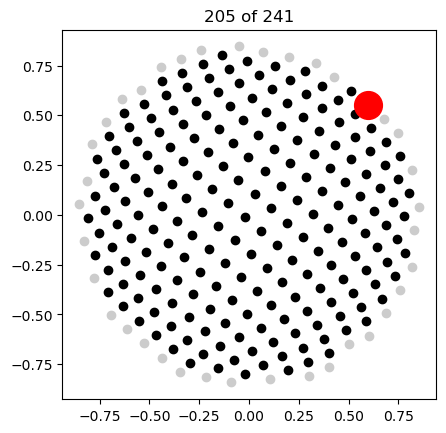

0.6201819471283058 0.744835014256428
<SkyCoord (AltAz: obstime=2023-03-09 02:06:57.155826, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (42.67590275, 35.5338081)>
<SkyCoord (ICRS): (ra, dec) in deg
    (161.88135053, 14.09608854)>
ra_h:dec_d 10.7920925441576:14.0959738878915
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000228.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000228.fits']
---------------------------------


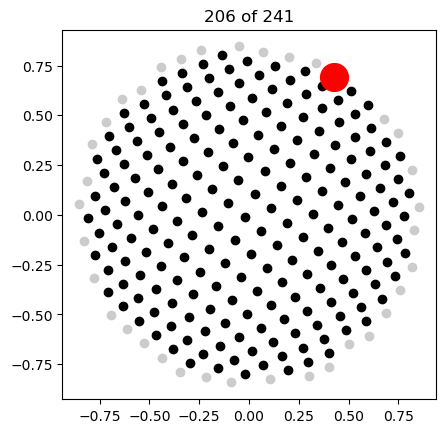

0.6190392473857581 1.0186945009714408
<SkyCoord (AltAz: obstime=2023-03-09 02:07:16.150685, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (58.36689552, 35.46833623)>
<SkyCoord (ICRS): (ra, dec) in deg
    (171.46691532, 5.42129727)>
ra_h:dec_d 11.4311506730141:5.42107195227484
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000229.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000229.fits']
---------------------------------


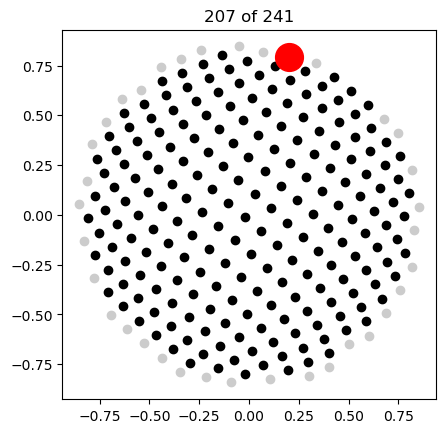

0.6152378033071418 1.3217903859561855
<SkyCoord (AltAz: obstime=2023-03-09 02:07:32.058079, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (75.73301052, 35.25052953)>
<SkyCoord (ICRS): (ra, dec) in deg
    (180.12290789, -5.82936245)>
ra_h:dec_d 12.0082157639794:-5.8294687100965
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000230.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000230.fits']
---------------------------------


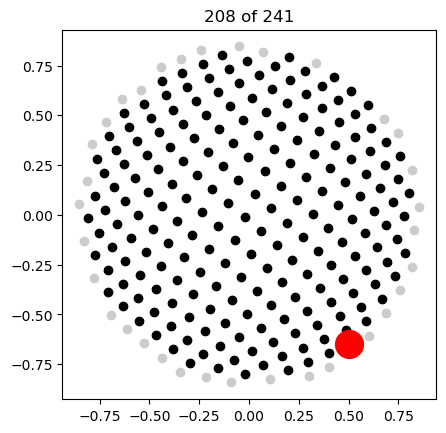

0.607275147886967 -0.9125634284186184
<SkyCoord (AltAz: obstime=2023-03-09 02:07:48.152701, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (307.71396701, 34.79430298)>
<SkyCoord (ICRS): (ra, dec) in deg
    (86.26865595, 9.35328851)>
ra_h:dec_d 5.75126050824044:9.35340059299516
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000231.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000231.fits']
---------------------------------


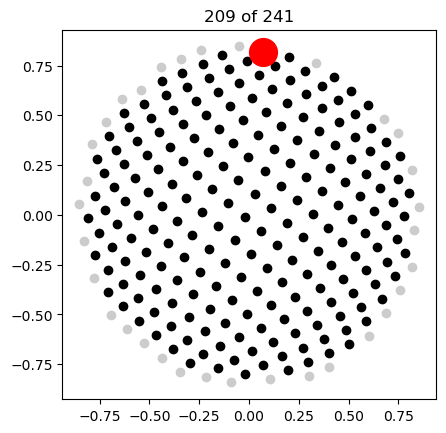

0.6069315170867638 1.4876013360656604
<SkyCoord (AltAz: obstime=2023-03-09 02:08:13.195535, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (85.23327815, 34.77461438)>
<SkyCoord (ICRS): (ra, dec) in deg
    (184.54997684, -12.39407571)>
ra_h:dec_d 12.3033483622312:-12.3943290658097
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000232.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000232.fits']
---------------------------------


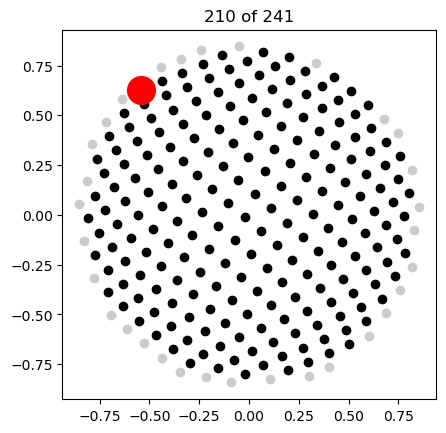

0.5963144409243277 2.2822459782036875
<SkyCoord (AltAz: obstime=2023-03-09 02:08:38.535156, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (130.76306236, 34.16630073)>
<SkyCoord (ICRS): (ra, dec) in deg
    (197.54071716, -48.01896045)>
ra_h:dec_d 13.1694101441255:-48.0193273249418
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000233.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000233.fits']
---------------------------------


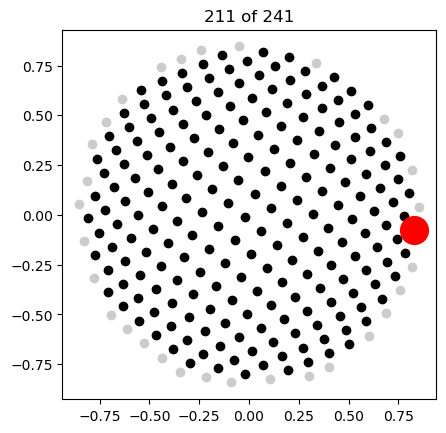

0.5915648294335567 -0.09183339294648643
<SkyCoord (AltAz: obstime=2023-03-09 02:09:04.830838, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (354.73833417, 33.89416803)>
<SkyCoord (ICRS): (ra, dec) in deg
    (122.83305331, 26.97408922)>
ra_h:dec_d 8.18887064423737:26.9740494572358
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000234.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000234.fits']
---------------------------------


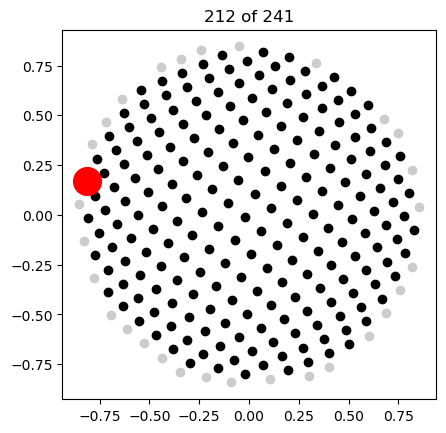

0.5907436558774912 2.938049448178801
<SkyCoord (AltAz: obstime=2023-03-09 02:09:29.634955, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (168.33783338, 33.84711826)>
<SkyCoord (ICRS): (ra, dec) in deg
    (188.85589989, -78.81696985)>
ra_h:dec_d 12.5904250250461:-78.816994270735
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000235.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000235.fits']
---------------------------------


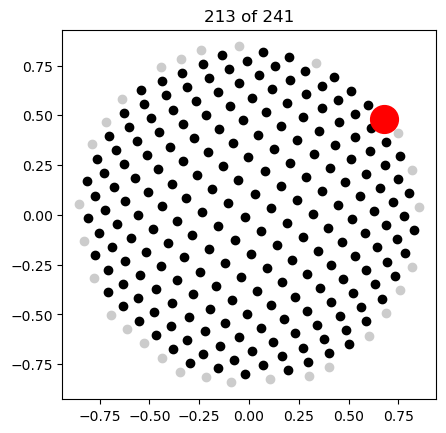

0.5907399142518989 0.6172549098215145
<SkyCoord (AltAz: obstime=2023-03-09 02:09:55.353635, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (35.36610122, 33.84690388)>
<SkyCoord (ICRS): (ra, dec) in deg
    (158.49591376, 18.92126246)>
ra_h:dec_d 10.5664064532101:18.9211840606244
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000236.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000236.fits']
---------------------------------


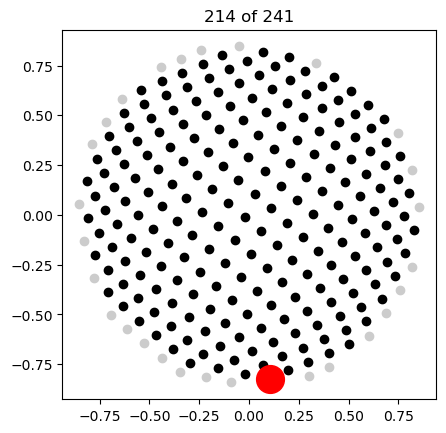

0.5890320919712173 -1.4441307659864024
<SkyCoord (AltAz: obstime=2023-03-09 02:10:23.036416, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (277.25740204, 33.74905287)>
<SkyCoord (ICRS): (ra, dec) in deg
    (71.19554641, -10.26413552)>
ra_h:dec_d 4.74637317833205:-10.2642450688013
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000237.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000237.fits']
---------------------------------


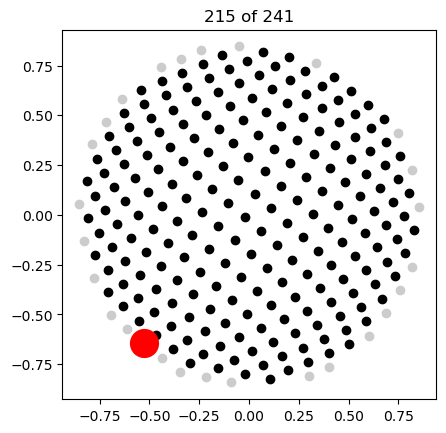

0.5858143703383712 -2.2554738468772433
<SkyCoord (AltAz: obstime=2023-03-09 02:10:46.020914, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (230.77086777, 33.564691)>
<SkyCoord (ICRS): (ra, dec) in deg
    (57.78656111, -46.86359041)>
ra_h:dec_d 3.85245478709841:-46.8636622844003
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000238.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000238.fits']
---------------------------------


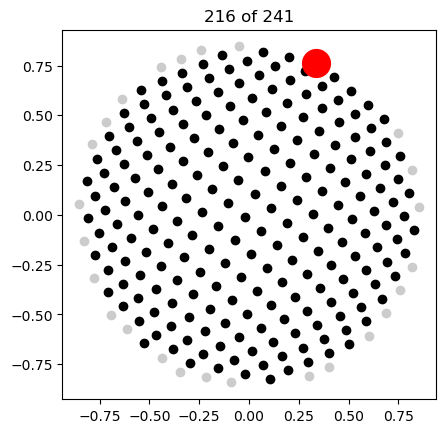

0.5812552259960257 1.1543367255027541
<SkyCoord (AltAz: obstime=2023-03-09 02:11:03.967925, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (66.13862251, 33.30347127)>
<SkyCoord (ICRS): (ra, dec) in deg
    (178.1594116, 1.81880972)>
ra_h:dec_d 11.8773087044226:1.81887159717264
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000239.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000239.fits']
---------------------------------


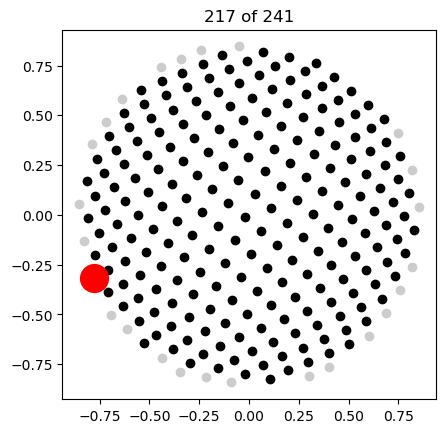

0.5764563324859151 -2.752508238688214
<SkyCoord (AltAz: obstime=2023-03-09 02:11:20.291643, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (202.29289485, 33.02851493)>
<SkyCoord (ICRS): (ra, dec) in deg
    (56.20792937, -70.5822176)>
ra_h:dec_d 3.74719872269229:-70.5822686541842
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000240.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000240.fits']
---------------------------------


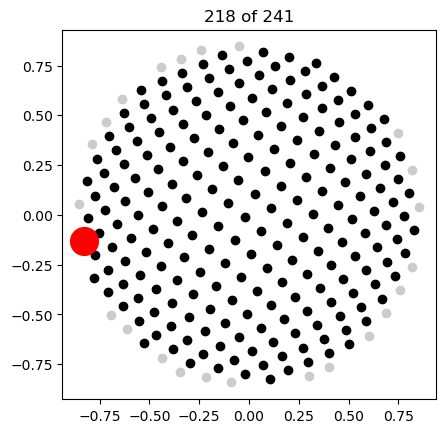

0.5751463868503288 -2.9831090322854203
<SkyCoord (AltAz: obstime=2023-03-09 02:11:42.027810, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (189.08044262, 32.95346057)>
<SkyCoord (ICRS): (ra, dec) in deg
    (68.41358821, -81.31877446)>
ra_h:dec_d 4.56090019202714:-81.318770483539
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000241.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000241.fits']
---------------------------------


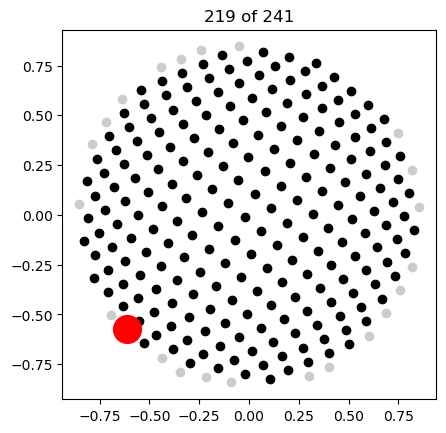

0.5749674625763662 -2.387482817164498
<SkyCoord (AltAz: obstime=2023-03-09 02:11:58.353327, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (223.20731092, 32.94320896)>
<SkyCoord (ICRS): (ra, dec) in deg
    (55.9635554, -53.06880202)>
ra_h:dec_d 3.73093561968135:-53.0685658281622
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000242.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000242.fits']
---------------------------------


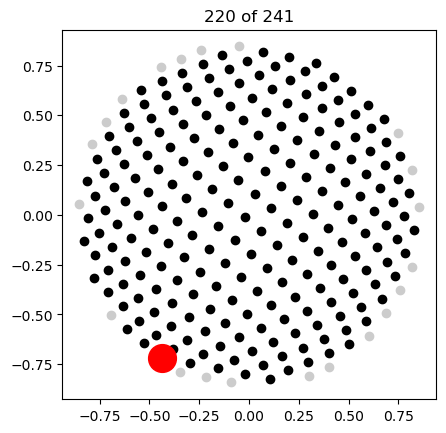

0.5740927203982111 -2.1196129968668576
<SkyCoord (AltAz: obstime=2023-03-09 02:12:16.160910, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (238.55512108, 32.89308993)>
<SkyCoord (ICRS): (ra, dec) in deg
    (58.81261475, -40.33555868)>
ra_h:dec_d 3.92085098491534:-40.3354619753214
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000243.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000243.fits']
---------------------------------


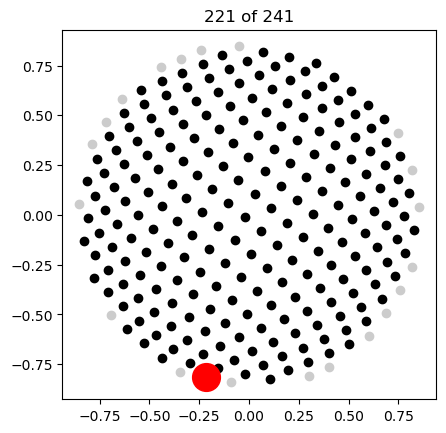

0.5692341765216915 -1.8290068697253168
<SkyCoord (AltAz: obstime=2023-03-09 02:12:31.752221, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (255.20562566, 32.61471587)>
<SkyCoord (ICRS): (ra, dec) in deg
    (62.97695363, -26.763614)>
ra_h:dec_d 4.19847519499279:-26.7634315979571
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000244.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000244.fits']
---------------------------------


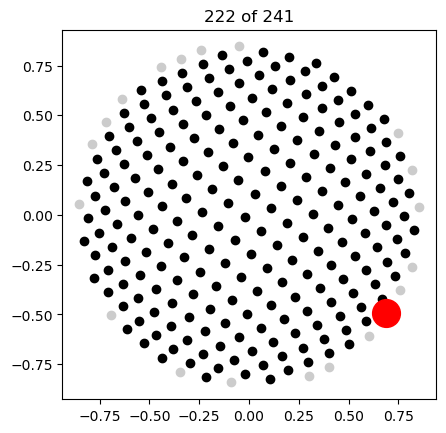

0.5667657395770956 -0.6213857359991737
<SkyCoord (AltAz: obstime=2023-03-09 02:12:47.741838, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (324.39721988, 32.47328485)>
<SkyCoord (ICRS): (ra, dec) in deg
    (97.19489185, 19.86687563)>
ra_h:dec_d 6.47967602900212:19.8668835194457
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000245.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000245.fits']
---------------------------------


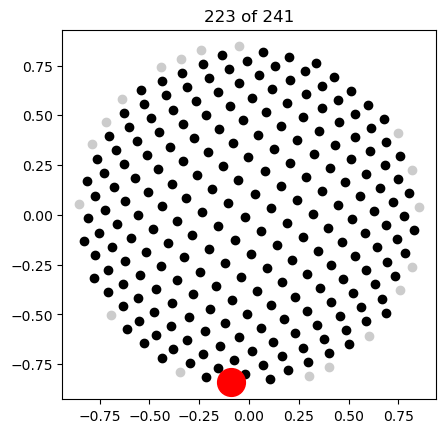

0.5622230300239158 -1.6747869423472257
<SkyCoord (AltAz: obstime=2023-03-09 02:13:06.440137, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (264.04177662, 32.21300677)>
<SkyCoord (ICRS): (ra, dec) in deg
    (65.5630111, -19.64003403)>
ra_h:dec_d 4.37086571776824:-19.6400114694822
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000246.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000246.fits']
---------------------------------


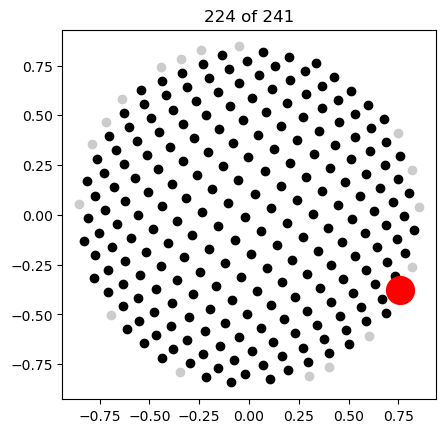

0.5621788226932143 -0.46107023980869594
<SkyCoord (AltAz: obstime=2023-03-09 02:13:24.633050, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (333.5826212, 32.21047387)>
<SkyCoord (ICRS): (ra, dec) in deg
    (104.5138273, 23.87598067)>
ra_h:dec_d 6.96760288743805:23.87604221181
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000247.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000247.fits']
---------------------------------


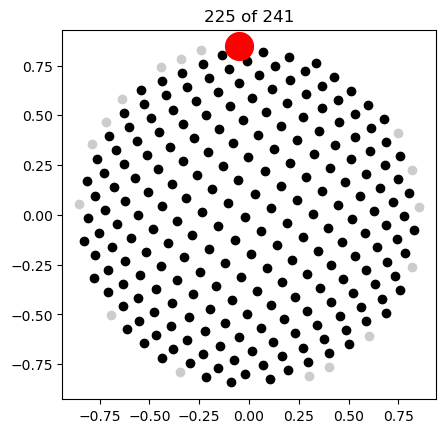

0.5599903352512194 1.6320249408007548
<SkyCoord (AltAz: obstime=2023-03-09 02:13:43.010115, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (93.50814117, 32.08508278)>
<SkyCoord (ICRS): (ra, dec) in deg
    (191.4819133, -17.50400937)>
ra_h:dec_d 12.7654789639053:-17.5042984574858
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000248.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000248.fits']
---------------------------------


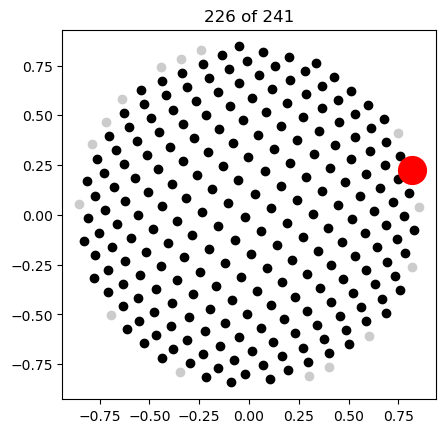

0.5576336495364073 0.2673934188933572
<SkyCoord (AltAz: obstime=2023-03-09 02:14:08.290567, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (15.32051437, 31.95005463)>
<SkyCoord (ICRS): (ra, dec) in deg
    (143.62921585, 27.43532069)>
ra_h:dec_d 9.57527827534829:27.435277875828
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000249.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000249.fits']
---------------------------------


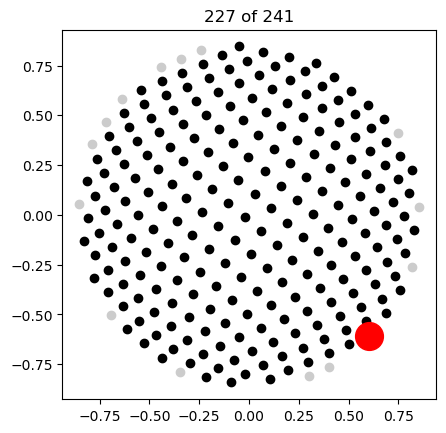

0.54887142002005 -0.7897122364972619
<SkyCoord (AltAz: obstime=2023-03-09 02:14:29.331119, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (314.75282182, 31.44801586)>
<SkyCoord (ICRS): (ra, dec) in deg
    (90.08396922, 15.80308846)>
ra_h:dec_d 6.00560786593237:15.8030303962855
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000250.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000250.fits']
---------------------------------


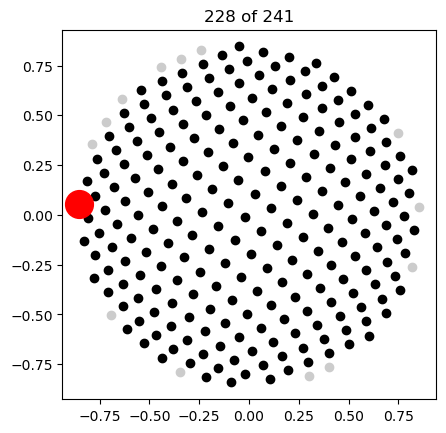

0.5484784120977776 3.079230405138253
<SkyCoord (AltAz: obstime=2023-03-09 02:14:50.554453, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (176.42690636, 31.42549817)>
<SkyCoord (ICRS): (ra, dec) in deg
    (180.17752152, -85.94925975)>
ra_h:dec_d 12.0118809187517:-85.9492450717727
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000251.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000251.fits']
---------------------------------


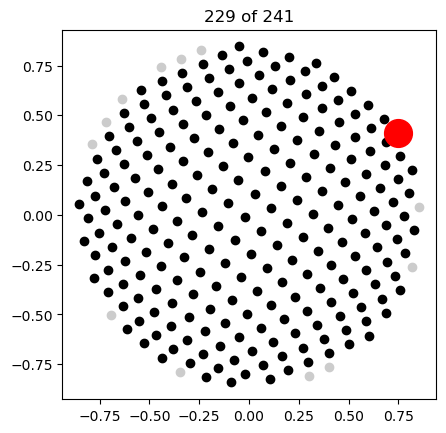

0.5459684434909648 0.500097211334084
<SkyCoord (AltAz: obstime=2023-03-09 02:15:14.990532, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (28.65345956, 31.28168756)>
<SkyCoord (ICRS): (ra, dec) in deg
    (155.9231511, 23.95574109)>
ra_h:dec_d 10.3948891394173:23.955681592539
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000252.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000252.fits']
---------------------------------


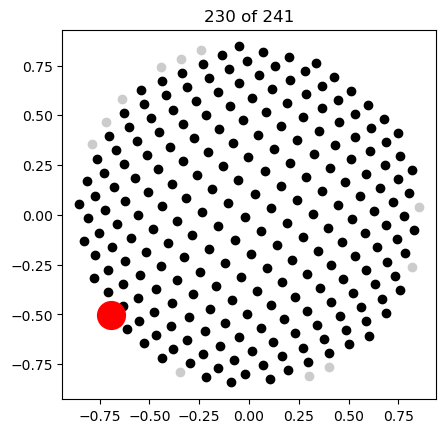

0.5453687710184815 -2.5116381937219354
<SkyCoord (AltAz: obstime=2023-03-09 02:15:43.071714, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (216.09373184, 31.24732886)>
<SkyCoord (ICRS): (ra, dec) in deg
    (52.88812861, -58.91189671)>
ra_h:dec_d 3.52589081275124:-58.9118319612748
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000253.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000253.fits']
---------------------------------


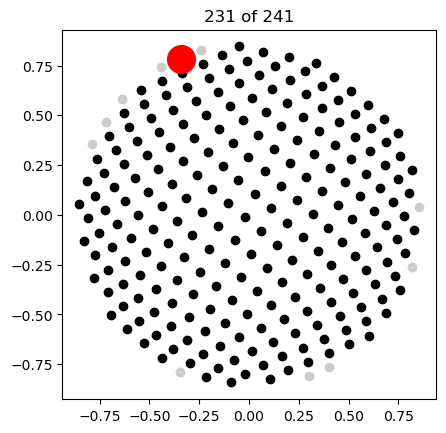

0.544016170059361 1.9794146846575922
<SkyCoord (AltAz: obstime=2023-03-09 02:16:04.075594, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (113.41210734, 31.16983053)>
<SkyCoord (ICRS): (ra, dec) in deg
    (199.377824, -33.12861788)>
ra_h:dec_d 13.291869076723:-33.1285694347638
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000254.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000254.fits']
---------------------------------


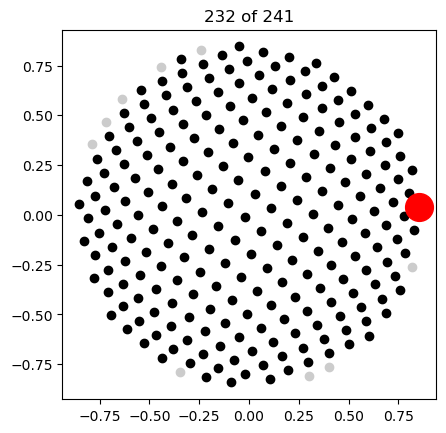

0.5419861245686464 0.04505141556906892
<SkyCoord (AltAz: obstime=2023-03-09 02:16:30.517217, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (2.58125597, 31.05351749)>
<SkyCoord (ICRS): (ra, dec) in deg
    (132.14167592, 29.97798189)>
ra_h:dec_d 8.80944617365428:29.9780830613261
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000255.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000255.fits']
---------------------------------


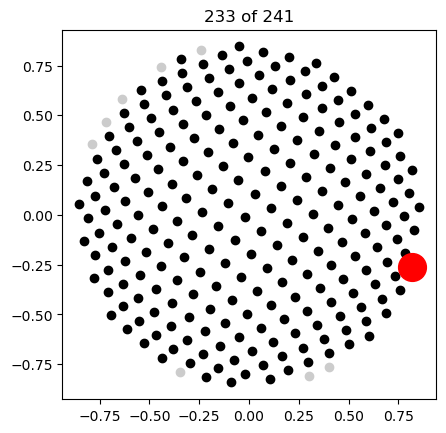

0.5401463100575578 -0.31012547405322727
<SkyCoord (AltAz: obstime=2023-03-09 02:16:55.586178, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (342.23111922, 30.94810389)>
<SkyCoord (ICRS): (ra, dec) in deg
    (112.49483309, 27.75446303)>
ra_h:dec_d 7.49965845516321:27.7544370444682
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000256.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000256.fits']
---------------------------------


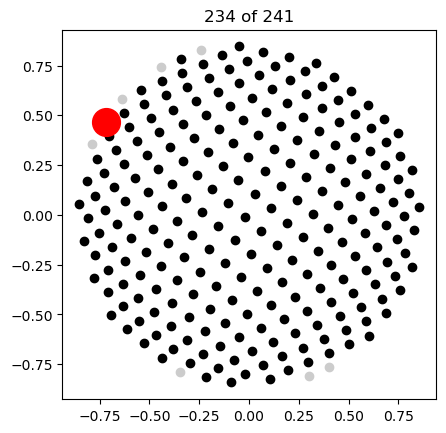

0.5391148685027076 2.5645126798637885
<SkyCoord (AltAz: obstime=2023-03-09 02:17:13.608456, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (146.93575306, 30.88900664)>
<SkyCoord (ICRS): (ra, dec) in deg
    (207.62739533, -61.27975373)>
ra_h:dec_d 13.8418656787241:-61.2798807727336
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000257.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000257.fits']
---------------------------------


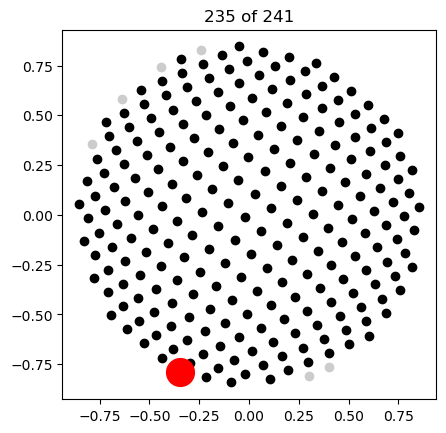

0.5354816316358422 -1.9850535126978353
<SkyCoord (AltAz: obstime=2023-03-09 02:17:30.547934, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (246.26481161, 30.6808375)>
<SkyCoord (ICRS): (ra, dec) in deg
    (59.45239994, -33.43986886)>
ra_h:dec_d 3.96350615813899:-33.4397461252954
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000258.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000258.fits']
---------------------------------


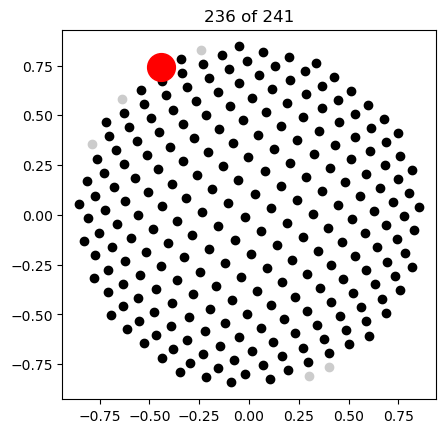

0.5314065150877647 2.106333354244688
<SkyCoord (AltAz: obstime=2023-03-09 02:17:55.418919, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (120.68401145, 30.44735052)>
<SkyCoord (ICRS): (ra, dec) in deg
    (202.73441845, -38.96562405)>
ra_h:dec_d 13.5156429379758:-38.9656506451042
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000259.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000259.fits']
---------------------------------


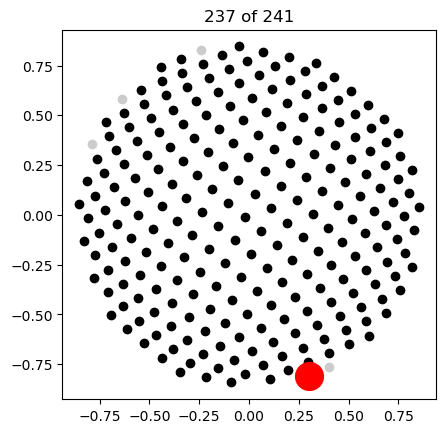

0.5306478843356696 -1.2139088916596723
<SkyCoord (AltAz: obstime=2023-03-09 02:18:21.454145, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (290.44814379, 30.40388418)>
<SkyCoord (ICRS): (ra, dec) in deg
    (76.18583284, 1.00942896)>
ra_h:dec_d 5.07906387038437:1.00956511213958
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000260.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000260.fits']
---------------------------------


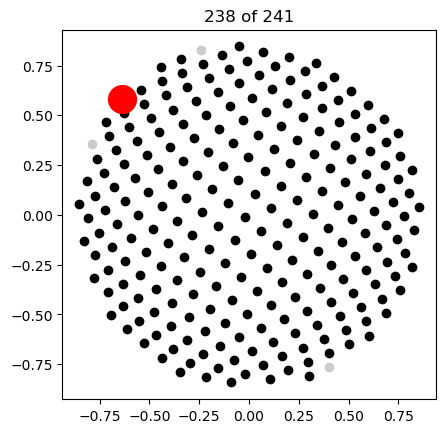

0.5296538498105565 2.4000215596433363
<SkyCoord (AltAz: obstime=2023-03-09 02:18:46.615478, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (137.51110611, 30.3469302)>
<SkyCoord (ICRS): (ra, dec) in deg
    (207.25375303, -53.16358638)>
ra_h:dec_d 13.8169516476637:-53.1638861651812
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000261.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000261.fits']
---------------------------------


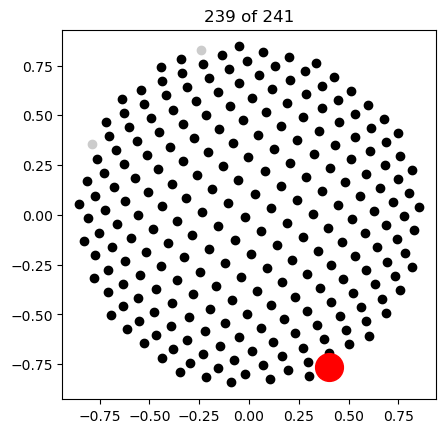

0.5295175168978008 -1.0878341540105976
<SkyCoord (AltAz: obstime=2023-03-09 02:19:10.845537, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (297.67169417, 30.3391189)>
<SkyCoord (ICRS): (ra, dec) in deg
    (80.07588155, 6.04124533)>
ra_h:dec_d 5.33841220696853:6.04147261290314
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000262.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000262.fits']
---------------------------------


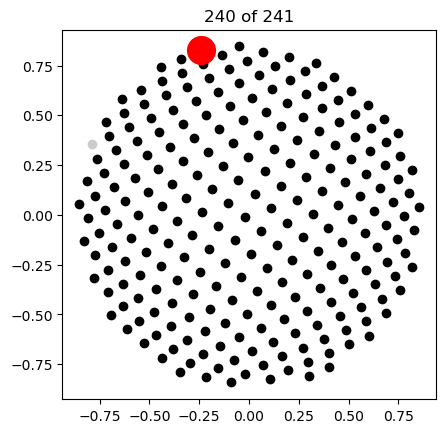

0.5284660301460635 1.8547960565626433
<SkyCoord (AltAz: obstime=2023-03-09 02:19:34.954468, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (106.2719859, 30.27887314)>
<SkyCoord (ICRS): (ra, dec) in deg
    (199.06990711, -27.01344195)>
ra_h:dec_d 13.2713500787575:-27.0135892279568
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000263.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000263.fits']
---------------------------------


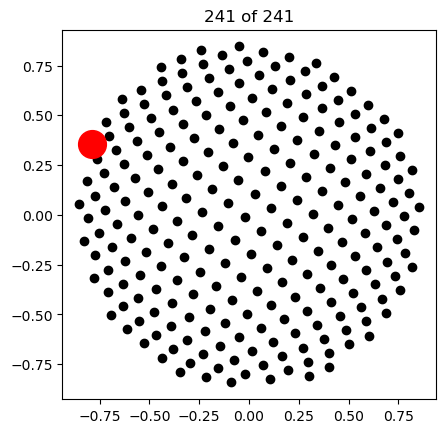

0.5280985884820611 2.7199649372001136
<SkyCoord (AltAz: obstime=2023-03-09 02:20:00.335900, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (155.84251133, 30.25782029)>
<SkyCoord (ICRS): (ra, dec) in deg
    (210.94232951, -68.89551823)>
ra_h:dec_d 14.0628678196443:-68.8956875321012
['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000264.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000264.fits']
---------------------------------


In [23]:
show_2d_plot = True


start_from = 137


for index in range(len(alt)):
    if index<start_from -1:
        continue
    current_alt = alt[index]
    current_az = az[index]
    if show_2d_plot:
        fig,ax = plt.subplots()
        ax.set_aspect("equal")
        ax.plot(x[:index],y[:index],"ko")
        ax.plot(x[index:],y[index:],"o",color="0.8")
        ax.plot(x[index],y[index],"ro",ms=20)
        ax.set_title("{} of {}".format(index+1,len(alt)))
        plt.show()

    print(current_alt,current_az)
    
    
    observing_location = EarthLocation.of_site("Las Campanas Observatory")#(lat='52.2532', lon='351.63910339111703', height=100*u.m)  
    observing_time = Time.now()
    
    await tel.km.slewStop()
    
    current_aa = SkyCoord(alt=current_alt*u.rad, az = current_az*u.rad, frame='altaz', obstime=Time.now(), location=observing_location)
    
    current_icrs = current_aa.transform_to(ICRS)
    print(current_aa)
    print(current_icrs)
    
    rc = await tel.pwi.gotoRaDecJ2000(current_icrs.ra.hour,current_icrs.dec.deg)
    ra_h, dec_d = rc.flatten().unpack("ra_j2000_hours", "dec_j2000_degs")
    print(f"ra_h:dec_d {ra_h}:{dec_d}")

    # dont do that on every exposure if you didn't change the pointing

    await tel.km.slewStart(ra_h, dec_d)
    
    #input("Telescope slewing done... proceed?")
    
    rc = await tel.agc.expose(7.)
    filenames = rc.flatten().unpack("*.filename")
    print(filenames)
    print("---------------------------------")

In [24]:
await tel.km.slewStop() # has to be done, otherwise k-mirror will rotate until it hits a limit
await tel.km.moveAbsolute(90., "DEG") # parking position (all mirror surfaces vertical)
await tel.km.moveAbsolute(90., "DEG") # check whether this position was reached (to make sure, i'll issue this command twice.. not ure if there is some kind of timeout or so)
await tel.pwi.park() # goto park position
await tel.pwi.setEnabled(False) # disengage motors (telescope should be free floating now)

{'is_enabled': False,
 'axis0': {'is_enabled': False},
 'axis1': {'is_enabled': False}}